In [1]:
#Import the necessary Python modules
import os
import sys
sys.path.insert(0,'..')
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMap
from folium import IFrame, Map, Marker, GeoJson, LayerControl


print(folium.__file__)
print(folium.__version__)

import pandas as pd
import numpy as np
import random
from random import randint
import pickle

import re

import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from colormap import rgb2hex

import base64
from io import BytesIO

#! conda install -c anaconda networkx
import networkx as nx

#! conda install -c anaconda seaborn 
import seaborn as sns
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});

from matplotlib.lines import Line2D
from IPython.display import IFrame

import json
from json2html import *

import pyproj

import branca
import math

#from elevation import *
%matplotlib inline 

/Users/ducvu/anaconda3/envs/map-gen/lib/python3.6/site-packages/folium/__init__.py
0.6.0


In [2]:
############################################################
def read_pickle(data_pickle):
    with open(data_pickle, 'rb') as f:
        datadict = pickle.load(f)
    return datadict


############################################################
def import_dss_data(data_pickle):
    obj = read_pickle(data_pickle)
    AllBusNames = obj[0]
    AllLoadNames = obj[1]
    AllLineNames = obj[2]
    AllTransNames = obj[3]
    AllCapacitorNames = obj[4]
    AllTransNames = obj[5]
    AllSubNames = obj[6]
    Circuit = obj[7]

    return AllBusNames , AllLoadNames, AllLineNames, AllTransNames,  AllCapacitorNames, AllTransNames, AllSubNames, Circuit


############################################################
def generate_network_data(data_pickle):

    AllBusNames , AllLoadNames, AllLineNames, AllTransNames,  AllCapacitorNames, AllTransNames, AllSubNames, Circuit = import_dss_data(data_pickle)
    listBusKeys = list(AllBusNames.keys())
    listBuses = []
    for i in listBusKeys[3:]:
        if AllBusNames[i]['Coorddefined'] == True:
            listBuses.append(AllBusNames[i])


    listSubKeys = list(AllSubNames.keys())
    listSubs = []
    for i in listSubKeys[3:]:
        #if AllSubNames[i]['Coorddefined'] == True:
        if (AllSubNames[i].get('Coorddefined', "False") == True) or (AllSubNames[i].get('Coorddefined', "False") == 1):
            listSubs.append(AllSubNames[i])


    listLineKeys = list(AllLineNames.keys())
    listLines = []
    for i in listLineKeys[3:]:
        listLines.append((AllLineNames[i]['Bus1'], AllLineNames[i]['Bus2']))


    listHighLines = []
    listLowLines = []

    listLowBuses = []
    listHighBuses = []

    voltageList = []
    for i in listBuses:

        kV_List = ['kVBase', 'kV_LN']

        if kV_List[0] in i.keys():
            voltageList.append(i[kV_List[0]])
        elif kV_List[1] in i.keys():
            voltageList.append(i[kV_List[1]])
    
    voltageList = list(set(voltageList))

    if len(voltageList) == 2:

        for i in listBuses:
            kV_List = ['kVBase', 'kV_LN']

            if kV_List[0] in i.keys():
                if i[kV_List[0]]*np.sqrt(3) == 34.5:
                    listHighBuses.append(i)
                elif i[kV_List[0]]*np.sqrt(3) == 13.2:
                    listLowBuses.append(i)

            elif kV_List[1] in i.keys():
                if i[kV_List[1]]*np.sqrt(3) == 4.16:
                    listHighBuses.append(i)
                elif i[kV_List[1]]*np.sqrt(3) == 0.48:
                    listLowBuses.append(i)

   
        lowBusNames = []
        highBusNames = []

        lowBusNames = [i['Name'] for i in listLowBuses]
        lowBusNames = list(set(lowBusNames))

        highBusNames = [i['Name'] for i in listHighBuses]
        highBusNames = list(set(highBusNames))

        listHighLines = [i for i in listLines if ((i[0] in highBusNames) &  (i[1] in highBusNames))]
        listLowLines = [i for i in listLines if ((i[0] in lowBusNames) &  (i[1] in lowBusNames))]

    return listBuses, listHighBuses, listLowBuses, listSubs, listLines, listHighLines, listLowLines, voltageList

In [3]:
############################################################
def extract_networks(data_pickle):
    data_name = data_pickle.split(os.sep)
    data_name = data_name[-1]

    listBuses, listHighBuses, listLowBuses, listSubs, listLines, listHighLines, listLowLines, voltageList = generate_network_data(data_pickle)
    
    bus_nodes = []
    high_bus_nodes = []
    low_bus_nodes = []
    sub_nodes = []
    edge_list = []
    high_edge_list = []
    low_edge_list = []
    
    nodes = {}
    edges = []
    
    if (not listHighBuses) and (not listLowBuses) and (not listHighLines) and (not listLowLines): 
        bus_nodes = [listBuses[i]['Name'] for i in range(len(listBuses))]
        bus_x_coord = [listBuses[i]['Coord_X'] for i in range(len(listBuses))]
        bus_y_coord = [listBuses[i]['Coord_Y'] for i in range(len(listBuses))]
        
        sub_nodes = [listSubs[i]['Name'] for i in range(len(listSubs))]
        sub_x_coord = [listSubs[i]['Coord_X'] for i in range(len(listSubs))]
        sub_y_coord = [listSubs[i]['Coord_Y'] for i in range(len(listSubs))]

        #nodes = {}
        for n in listBuses:
            nodes.update({n['Name']: (n['Coord_X'], n['Coord_Y'])})

        for n in listSubs:
            nodes.update({n['Name']: (n['Coord_X'], n['Coord_Y'])})

        edge_list = listLines
        edges.extend(edge_list)
        

    else:
        high_bus_nodes = [listHighBuses[i]['Name'] for i in range(len(listHighBuses))]
        low_bus_nodes  = [listLowBuses[i]['Name'] for i in range(len(listLowBuses))]
        sub_nodes = [listSubs[i]['Name'] for i in range(len(listSubs))]

        #nodes = {}
        for n in listHighBuses:
            nodes.update({n['Name']: (n['Coord_X'], n['Coord_Y'])})
    
        for n in listLowBuses:
            nodes.update({n['Name']: (n['Coord_X'], n['Coord_Y'])})
    
        for n in listSubs:
            nodes.update({n['Name']: (n['Coord_X'], n['Coord_Y'])})

        high_edge_list = listHighLines
        low_edge_list = listLowLines
        
        edges.extend(high_edge_list)
        edges.extend(low_edge_list)
        
    edges = [i for i in edges if i[0]  in nodes and i[1] in nodes ]    
    
    return bus_nodes, high_bus_nodes, low_bus_nodes, sub_nodes, edge_list, high_edge_list, low_edge_list, nodes, edges


############################################################
def generate_dataframe(data_pickle, coord, scale_x, scale_y):
    
    bus_nodes, high_bus_nodes, low_bus_nodes, sub_nodes, edge_list, high_edge_list, low_edge_list, nodes, edges  = extract_networks(data_pickle)
    
    # generate dataframe for nodes
    scaler = lambda xy_coord: scale_xy(xy_coord, scale_x, scale_y)
    
    location_list = list(map(scaler, list(nodes.values()) ))

    lats, lons = conv_xy_to_latlon(location_list, coord)

    df_node = pd.DataFrame(
        {'Node': list(nodes.keys()),
         'lat': lats,
         'lon': lons
        })


    centroid_coord = [ df_node['lat'].mean(), df_node['lon'].mean() ]
    
    # generate dataframe for edges
    df_line = pd.DataFrame(
    {'Node A': list(map(list, zip(*edges)))[0],
     'Node B': list(map(list, zip(*edges)))[1]
    })
    
    df_line = find_geometry_points(df_node, df_line)

    return df_node, df_line, centroid_coord

In [4]:
############################################################
def conv_xy_to_latlon(xy_list, origin_lat_lon):
    # lat_1=40.666667, lat_2=41.033333,
    origin_lat, origin_lon = origin_lat_lon
    lats, lons = [], []
    
    for x, y in xy_list:
        pnyc = pyproj.Proj( proj='tmerc', datum='NAD83', 
                           lat1=41.7557, lat2=41.6860,
                           lat_0=origin_lat, lon_0=origin_lon, 
                           x_0=0, y_0=0.0)
    
        lon, lat = pnyc(x, y, inverse=True)
        #print(lat, lon)
        lats.append(lat)
        lons.append(lon) 
        
    return lats, lons


############################################################
def find_geometry_points(df_node, df_edge):
    #node_label_dict = dict([(node,(lat, lon)) for node, lat, lon in zip(df_node['Node'], df_node['lat'],df_node['lon'])])
    node_label_dict = {x[0]: x[1:] for x in df_node.itertuples(index=False)}

    node_a = [node_label_dict[i] for i in df_edge['Node A'].tolist()]
    node_b = [node_label_dict[i] for i in df_edge['Node B'].tolist()]
    node_ab = list(zip(node_a,node_b))
    df_edge['Node_A_coord'] = node_a
    df_edge['Node_B_coord'] = node_b
    df_edge['Node_AB_coord'] = node_ab
    return df_edge



############################################################
def scale_xy(xy_coord, scale_x, scale_y):
    return ( xy_coord[0]%scale_x, xy_coord[1]%scale_y )  

'''
############################################################
def scale_xy(xy_coord, scale_x, scale_y):
    
    return ( xy_coord[0]*scale_x, xy_coord[1]*scale_y)  
'''


############################################################
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# https://andrew.hedges.name/experiments/haversine/
from math import sin, cos, sqrt, atan2, radians


############################################################
def spherical_distance(origin, destination):
    # approximate radius of earth in km
    R = 6373.0

    lat1, lon1 = origin
    lat2, lon2 = destination
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    print("The distance between ({}, {}) and ({}, {}): {} km".format(lat1, lon1, lat2, lon2, distance))
    return  distance


'''
def spherical_distance(origin, destination):
    
    lat1, lon1 = origin
    lat2, lon2 = destination
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    
    phi1 = 0.5*np.pi - lat1
    phi2 = 0.5*np.pi - lat2
    r = 0.5*(6378137 + 6356752) # mean radius in meters
    t = sin(phi1)*sin(phi2)*cos(lon1-lon2) + cos(phi1)*cos(phi2)
    distance = r * acos(t)
    print("The distance between ({}, {}) and ({}, {}): {} km".format(lat1, lon1, lat2, lon2, distance))
    return distance 
    
'''

############################################################
def generate_probabilty(n):
    mu, sigma = 0, 0.1 # mean and standard deviation
    #return np.random.normal(mu, sigma, n)
    return [ random.random() for i in range(n) ]


############################################################
def generate_discrete_probability(n):
    #random.sample(range(0, n), 2) 
    return [random.randrange(0, 2, 1) for _ in range(n)]


############################################################
#!pip install geopy
import geopy
from geopy.distance import VincentyDistance

def calculate_new_latlon_geopy(lat1, lon1):
    # given: lat1, lon1, b = bearing in degrees, d = distance in kilometers
    b = 2*np.pi
    d = 68

    origin = geopy.Point(lat1, lon1)
    destination = VincentyDistance(kilometers=d).destination(origin, b)

    lat2, lon2 = destination.latitude, destination.longitude  
    return lat2, lon2


############################################################
def offset_latlon(df_node, df_line):
    
    new_location = lambda x: calculate_new_latlon_geopy(x[0], x[1])

    location_list = list(map(new_location, list(zip(df_node['lat'], df_node['lon']))))

    df_node_new = pd.DataFrame(location_list, columns=['lat', 'lon'])
    df_node_new['Node'] = df_node['Node']
    
    # reorder columns
    df_node_new = df_node_new[['Node', 'lat', 'lon']]
    
    df_line_new = df_line.drop(['Node_A_coord', 'Node_B_coord', 'Node_AB_coord'], 1)
    df_line_new = find_geometry_points(df_node_new, df_line_new)  
    return df_node_new, df_line_new

## Folium visualization functions

In [5]:
############################################################
def df_to_html(row, info_name = None):
    
    #style = '<style> #myDIV { width: 360px;height: 50px;background-color: #FF7006;color: white;text-align:center;font-family:courier;font-size:10px;} </style> <div id="myDIV"> <h1>' + str(info_name) + '</h1> </div>' 
    style = '<style> #myDIV { width: 360px;height: 50px;background-color: #99bbff;color: white;text-align:center;font-family:courier;font-size:10px;} </style> <div id="myDIV"> <h1>' + str(info_name) + '</h1> </div>' 
    newdf = pd.DataFrame(row).copy(deep=True)

    html = newdf.to_html()
    html = html.replace('\n', ' ')
    html = html.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html =  style + html


    #remove content between <thead>  </thead>
    pattern = r'.*?\<thead>(.*)\</thead>.*'
    match = re.search(pattern, html)
    header = match.group(1)
    html = html.replace(header,'')


    #replace <tr> with <tr style="text-align: left;">
    html = html.replace('<tr>','<tr style="text-align: left;">')
    return html


############################################################
def generate_baseMap(default_location=[40.5397293,-74.6273494], default_zoom_start=12, default_tile='openstreetmap'):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start, tiles=default_tile)
    return base_map



############################################################
from folium import IFrame

##  Create folium polyline layer
# make folium polyline for each edge in df_edge
def generate_folium_polyline(edge, attr, edge_width, edge_opacity=0.5, prob_name = None, info_name = None):
    """
    Turn a row from the gdf_edges GeoDataFrame into a folium PolyLine 
    Parameters
    ----------
    edge : GeoSeries
        a row from the gdf_edges GeoDataFrame
    edge_width : numeric
        width of the edge lines
    edge_opacity : numeric
        opacity of the edge lines
    Returns
    -------
    pl : folium.PolyLine
    """
    locations = [(coord[0], coord[1]) for coord in edge['Node_AB_coord']]
    
    #edge color
    if prob_name != None:
        #edge_color = edge[prob_name]
        edge_color = prob_name
    else:
        edge_color = '#339FFF'
        #edge_color = '#00FF7F' # green color
        #edge_color = '8A837B' # brown color
        #edge_color = 'EFFA07'
        
        
        
    #popup attributes
    #values = [edge[i] for i in attr]
    
    #d = dict(zip(attr,values))
    #popup_text = json.dumps(d)
    ##popup = folium.Popup(html=popup_text)
    #html = json2html.convert(json = popup_text)
    #iframe = IFrame(html=html, width=500, height=300)
    
    row = edge[attr]
    html = df_to_html(row, info_name = info_name)
    iframe = IFrame(html=html, width=360, height=240)
    popup = folium.Popup(iframe, max_width=2650)
    
    
    # create a folium polyline with attributes
   # pl = folium.PolyLine(locations=locations, popup=popup, color=edge_color, weight=edge_width, opacity=edge_opacity)
    pl = folium.PolyLine(locations=locations, color=edge_color, weight=edge_width, opacity=edge_opacity)
    return pl


############################################################
#create folium polyline layer
def add_polyline(mapobj, df, attr = [], layer_name = 'Default', prob_name = None, info_name = None):
    """
    Add the layer of folium polylines from edges GeoDataFrame
    Parameters
    ----------
    mapobj : Folium map object
        Folium map object
    gdf_edges : GeoDataFrame
        edges GeoDataFrame
    Returns
    -------
    layer of folium polylines
    """
    #attr = df.columns[2:] 
    
    #polyline_layer = folium.FeatureGroup(name = str(layer_name), overlay=False)
    polyline_layer = folium.FeatureGroup(name = str(layer_name))
    
    for _, row in df.iterrows():
        #pl = generate_folium_polyline(row, attr, edge_width=row['probability'], edge_opacity=3, prob_name=prob_name, info_name = info_name)
        pl = generate_folium_polyline(row, attr, edge_width=5, edge_opacity=3, prob_name=prob_name, info_name = info_name)
        pl.add_to(polyline_layer)

    polyline_layer.add_to(mapobj)
    
    return mapobj


############################################################
## Create point cluster layer
def display_image_in_html(imgage):
    encoded_image = base64.b64encode(open(imgage, 'rb').read())
    decoded_image = base64.b64decode(encoded_image)
    image_url = BytesIO(decoded_image)
    return image_url


############################################################
#create point cluster layer
def add_point_clusters(mapobj, df_node, attr = [], node_image = None, node_name = None, icon_size=(15, 15), info_name = None):
    """
    Add the layer of point locations from edges GeoDataFrame
    Parameters
    ----------
    mapobj : map object
        Folium map object
    gdf_nodes : GeoDataFrame
        nodes GeoDataFrame
    Returns
    -------
    layer of point locations
    """      

    #point_layer = folium.FeatureGroup(name = node_name, overlay=False)
    point_layer = folium.FeatureGroup(name = node_name)

    for _, row in df_node.iterrows(): 
        
        icon_url = node_image
        #icon_url = display_image_in_html(node_image)
        
        # Create popup on the map
        #popup = folium.Popup(label, parse_html=True)  
        
        #popup attributes        
        #values = [row[i] for i in attr]
        #d = dict(zip(attr,values))
        #popup_text = json.dumps(d)    
        #html = json2html.convert(json = popup_text)
    
        #iframe = IFrame(html=html, width=400, height=200)
        #popup = folium.Popup(iframe, max_width=2650)
    
        row = row[attr]
        html = df_to_html(row, info_name = info_name)
        iframe = IFrame(html=html, width=360, height=240)
        popup = folium.Popup(iframe, max_width=2650)
        
        if row['Node'] == 'sourcebus':
            #icon_url = 'https://raw.githubusercontent.com/dvu4/grid_folium/master/data/substation.png'
            icon_url = 'https://static.thenounproject.com/png/192984-200.png'
            icon = folium.features.CustomIcon(icon_url, icon_size=(28, 30))
        #else:
            #icon = folium.features.CustomIcon(icon_url, icon_size=icon_size)
        
            # extract lat and long coordinates to assign to the marker
            folium.Marker(np.array([row.lat, row.lon]), popup=popup, icon=icon).add_to(point_layer)
        
    
        #FastMarkerCluster(np.array([row.lat, row.lon]), popup=popup, icon=icon).add_to(point_layer)
    #Create a Folium feature group for this layer, since we will be displaying multiple layers
    point_layer.add_to(mapobj)
    return mapobj

############################################################
#create heatmap data layer
def generate_heat_data(df_line):
    n = len(df_line)
    p = generate_probabilty(n)
    dp = generate_discrete_probability(n)
    
    middle_point = [(np.mean([node[0][0], node[1][0]]), np.mean([node[0][1], node[1][1]]) )  for node in df_line['Node_AB_coord'].tolist()]
    df_heat_map = pd.DataFrame(middle_point, columns=['lat', 'lon'])
    df_heat_map['probability'] = p
    df_heat_map['discrete_probability'] = dp
    
    #heat_data = df_new.as_matrix()
    heat_data = df_heat_map[['lat', 'lon', 'probability']].values.tolist()
    heat_data_dp = df_heat_map[['lat', 'lon', 'discrete_probability']].values.tolist()
    return heat_data, heat_data_dp, df_heat_map



############################################################
#create heatmap layer
def add_heatmap(mapobj, df, attr = [], radius = 20, heat_name = None, info_name = None, discrete_layer=False):

    heatmap_layer = folium.FeatureGroup(name = str(heat_name))
    
    heat_data, heat_data_dp, df_heat_map = generate_heat_data(df)
        
    #colormap =  {0.4: 'blue', 0.65: 'green', 1: 'red'}
    #colormap =  {0.6: 'blue', 0.98: 'lime', 1: 'red'}
    #colormap = {0.0: 'pink', 0.3: 'blue', 0.5: 'green',  0.7: 'yellow', 1.0: 'red'}

    
    # Setup colormap
    colors = ['#FFC0CB', '#0000FF', '#008000', '#FFFF00', '#FF0000']
    #colors = ['#2b83ba',  '#abdda4',  '#ffffbf',  '#fdae61',  '#d7191c']

    vmin   = np.min(df_heat_map['probability'])
    vmax   = np.max(df_heat_map['probability'])
    levels = len(colors)
    #cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax, aption = 'Failure probability').to_step(levels)
    cm1     = branca.colormap.LinearColormap(['b','c','g','y','r'], vmin=vmin, vmax=vmax, caption = 'Failure probability')
    cm2     = branca.colormap.LinearColormap(['black','orange','r'], vmin=vmin, vmax=vmax, caption = 'Damage status')
    
    tooltip = '<i>Click here</i>'


    
    if not discrete_layer:          
        for _, row in df_heat_map.iterrows(): 
            
            row = row[attr]
        
            html = df_to_html(row, info_name = info_name)
            iframe = IFrame(html=html, width=360, height=240)
            popup = folium.Popup(iframe, max_width=2650)
        
            #fill_color='#FFFFFF',
            folium.Circle(np.array([row['lat'], row['lon'] ]), 
                          radius=10,
                          popup=popup,
                          fill=True, 
                          opacity = 0.005, 
                          stroke = False,
                          tooltip = tooltip,
                          color = '#FFFFFF').add_to(heatmap_layer)

        heatmap_layer.add_to(mapobj)   
    
    
        #colormap = {0.0: 'pink', 0.3: 'blue', 0.5: 'green',  0.7: 'yellow', 1.0: 'red'}
        #colormap = {0.0: '#2b83ba', 0.3: '#abdda4', 0.5: '#ffffbf',  0.7: '#fdae61', 1.0: '#d7191c'}  
        colormap = {0.0: 'blue', 0.3:'coral', 0.5: 'green', 0.7: 'yellow', 1.0: 'red'}
        HeatMap(heat_data, 
                name = heat_name, 
                radius = radius, 
                gradient = colormap, 
                min_opacity=0.2,
                max_val=float(df_heat_map['probability'].max()),
                blur=15,
                max_zoom=1).add_to(folium.FeatureGroup(name = str(heat_name)).add_to(mapobj))
        
        
        
        mapobj.add_child(cm1)


    else:
        for _, row in df_heat_map.iterrows(): 
            
            row = row[attr]
        
            html = df_to_html(row, info_name = info_name)
            iframe = IFrame(html=html, width=360, height=240)
            popup = folium.Popup(iframe, max_width=2650)
        
            #fill_color='#FFFFFF',
            folium.Circle(np.array([row['lat'], row['lon'] ]), 
                          radius=10,
                          popup=popup,
                          fill=True, 
                          opacity = 0.005, 
                          stroke = False,
                          tooltip = tooltip,
                          color = '#FFFFFF').add_to(heatmap_layer)


        heatmap_layer.add_to(mapobj)   
    
    
        colormap = {0.0: '000000', 0.5: '#8b0000', 1.0: 'd80000'}
        
        HeatMap(heat_data_dp, 
                name = heat_name, 
                radius = radius, 
                gradient = colormap, 
                min_opacity = .01,
                max_zoom=1).add_to(folium.FeatureGroup(name = str(heat_name)).add_to(mapobj))
        
        mapobj.add_child(cm2)
    #heatmap_layer.add_to(mapobj)
    #heatmap_layer.add_to(folium.FeatureGroup(name = str(heat_name)).add_to(mapobj))
    #mapobj.add_child(folium.ClickForMarker(popup='Potential Location'))  
    

    
    return mapobj

In [153]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage

def generate_legend_property(geojson):
    unique_titles = []
    for i in geojson['features']:
        n = round(float(i['properties']['title']), 2)
        unique_titles.append(n)
        unique_titles = sorted(list(set(unique_titles)), reverse=True)

    properties_dict = {str(i): str(x) for i,x in enumerate(unique_titles)}
    return properties_dict
 
def generate_contour(mapobj, centroid_coord, nb_class = 10, contour_name = None, df_flood = None):
    
    # Setup colormap
    #colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
    #levels = len(colors)
    #cm     = branca.colormap.LinearColormap(colors, vmin=0, vmax=1).to_step(levels)
    #cm     = branca.colormap.LinearColormap(['b','c','g','y','r'], vmin=0, vmax=1)
    cm     = branca.colormap.LinearColormap(['#0000FF', '#6495ED', '#00FFFF', '#008000', '#8FBC8F', '#FFFF00', '#FFA500', '#FFA07A', '#FF6347', '#FF0000'], 
                                            vmin=1, 
                                            vmax=10, 
                                            caption = contour_name)  
    
    if df_flood is not None:

        # The original data
        x_orig = np.asarray(df_flood['longitude  (x coordinates)'].tolist())
        y_orig = np.asarray(df_flood['latitude (y coordinates)'].tolist())
        z_orig = np.asarray(df_flood['Flood depth (ft)'].tolist())
 
        # Make a grid
        x_arr          = np.linspace(-88.5231, -88.3651, 80)
        y_arr          = np.linspace(41.6859,  41.8039,  60)
        x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
    
        # Grid the values
        #z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='nearest')
        z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
        #z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='cubic')
        #z_mesh = np.random.rand(60,80) 
        
        # Gaussian filter the grid to make it smoother
        sigma = [5, 5]
        z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')


    
    else:
        # Create a dataframe with fake data
        df = pd.DataFrame({
            'longitude':   np.random.normal(centroid_coord[1],    0.075,     10000),
            'latitude':    np.random.normal(centroid_coord[0],    0.075,     10000),
            'probability': [random.randint(1,10) for i in range(10000)]
            #'probability': np.random.normal(0, 1, 10000)})
        })
            

        # The original data
        x_orig = np.asarray(df.longitude.tolist())
        y_orig = np.asarray(df.latitude.tolist())
        z_orig = np.asarray(df.probability.tolist())
 
        # Make a grid
        x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 1000)
        y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 1000)
        x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 
        wave = 0.75*(np.sin(2.*y_mesh)**8*np.cos(4.*x_mesh))
        mean = 0.5*np.cos(2.*y_mesh)*((np.sin(2.*y_mesh))**2 + 2.)
        z_mesh = wave + mean
     
        
    # Create the contour
    #contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors)
    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, nb_class, alpha=0.5, cmap=plt.cm.jet)
 
    # Convert matplotlib contourf to geojson
    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=0.5)
    
    '''
    #A Python dictionary containing properties to be added to each GeoJSON Feature
    properties_dict={'0.80 ' : '10',
                     '0.60 ' : '9',
                     '0.40 ' : '8',
                     '0.20 ' : '7',
                     '0.00 ' : '6',
                     '-0.20 ': '5',
                     '-0.40 ': '4',
                     '-0.60 ': '3', 
                     '-0.80 ': '2',
                     '-1.00 ': '1'}
    
    
    
    # The JSON was encoded twice (WEIRD !!!)
    geojson = json.loads(geojson) 

    properties_dict = generate_legend_property(geojson)
    
    #Loop over GeoJSON features and add the new properties       
    for feat in geojson['features']:
        #print(feat['properties']['title'])
        if feat['properties']['title'] in properties_dict.keys():
            key_match = feat['properties']['title'] 
            feat['properties']['flood depth'] = properties_dict[key_match]
    
    

    # Plot the contour plot on folium
    folium.GeoJson(
            geojson,
            name = contour_name,
            style_function=lambda x: {
                'color':     x['properties']['stroke'],
                'weight':    x['properties']['stroke-width'],
                'fillColor': x['properties']['fill'],
                'opacity':   0.6},
            tooltip=folium.GeoJsonTooltip(fields=['title'],
                                      aliases=['<div style="background-color: lightyellow; color: black; padding: 3px; border: 2px solid black; border-radius: 3px;">'+item+'</div>' for item in ['title']],
                                      style="font-family: san serif;",
                                      localize=True)).add_to(mapobj)
 
    '''
    
    
    # Plot the contour plot on folium
    folium.GeoJson(
            geojson,
            name = contour_name,
            style_function=lambda x: {
                'color':     x['properties']['stroke'],
                'weight':    x['properties']['stroke-width'],
                'fillColor': x['properties']['fill'],
                'opacity':   0.6}).add_to(mapobj)    
    
    # Add the colormap to the folium map
    mapobj.add_child(cm) 
    
    return mapobj

In [58]:
from folium import IFrame

def plot_grid(data_pickle, default_coord, scale_x, scale_y, df_node=None, df_line=None, df_flood = None):

    name = data_pickle.split('/')[-1].split('.')[0]
    
    if df_node is  None and df_line is None:
        df_node, df_line, centroid_coord = generate_dataframe(data_pickle, default_coord, scale_x, scale_y)
    else:
        centroid_coord = [ df_node['lat'].mean(), df_node['lon'].mean() ]
    
    
    folium_map = generate_baseMap(default_location=centroid_coord)


    folium_map = generate_contour(folium_map, 
                                 centroid_coord, 
                                 contour_name = 'Weather metric distribution',
                                 df_flood = df_flood)
    
    #Update basemap with Polyline Layer
    folium_map = add_polyline(folium_map, 
                             df_line, 
                             attr = ['Node A', 'Node B'],
                             layer_name = 'Grid '+ name,
                             info_name = 'Line Information')

    node_icon = 'https://raw.githubusercontent.com/dvu4/grid_folium/master/data/Blue_icon.png'

    #Update basemap with point cluster layer
    folium_map = add_point_clusters(folium_map, 
                                   df_node, 
                                   attr = ['Node', 'lat', 'lon'], 
                                   node_image = node_icon, 
                                   node_name = 'Node '+ name,
                                   info_name = 'Substation')
    

    
   
    folium_map = add_heatmap(folium_map, 
                            df_line, 
                            attr = ['lat', 'lon', 'probability'], 
                            radius = 20, 
                            heat_name = 'Probability failure for ' + name,
                            info_name = 'Failure Probability',
                            discrete_layer=False)

    
    folium_map = add_heatmap(folium_map, 
                            df_line, 
                            attr = ['lat', 'lon', 'discrete_probability'], 
                            radius = 20, 
                            heat_name = 'Damage status ' + name,
                            info_name = 'Electric Component',
                            discrete_layer=True)
    
    #Update heatmap 
    
    '''
    # List comprehension to make out list of lists
    heat_name = 'probability failure for ' + name
    #colormap =  {0.4: 'blue', 0.65: 'green', 1: 'red'}
    #colormap = None
    #colormap =  {.6: 'blue', .98: 'lime', 1: 'red'}
    colormap = {0.0: 'pink', 0.3: 'blue', 0.5: 'green',  0.7: 'yellow', 1.0: 'red'}
    
    
    # Plot it on the map
    HeatMap(heat_data, name = heat_name, radius = 10, gradient = colormap, max_zoom=10).add_to(folium_map)
        
    '''


 

    
    folium.TileLayer('stamentoner').add_to(folium_map)
    folium.TileLayer('stamenwatercolor').add_to(folium_map)
    folium.TileLayer('Stamen Terrain').add_to(folium_map)
    folium.TileLayer('cartodbdark_matter').add_to(folium_map)
    folium.TileLayer('cartodbpositron').add_to(folium_map)

    
    # Fullscreen
    plugins.Fullscreen(position='topright',
                       title='Expand me',
                       title_cancel='Exit me',
                       force_separate_button=True).add_to(folium_map)


    folium_map.add_child(folium.LayerControl(collapsed=True)) #Add layer control to toggle on/off
    #gfolium_map.get_root().add_child(folium.LayerControl())
    #folium.LayerControl().add_to(folium_map)
    
    
    filepath = os.getcwd() + '/' + name + '.html'    
    folium_map.save(filepath)
    
    IFrame(filepath, width=600, height=500) #display map

In [55]:
data_path = "/Users/ducvu/Desktop/restoration_tool_final_3/test_system_data/"

data_names = ["EPRI_ckt5/ckt5_system_data.dat", 
              "EPRI_ckt7/ckt7_system_data.dat", 
              "EPRI_ckt24/ckt24_system_data.dat", 
              "IEEE8500/IEEE8500_system_data.dat", 
              "IEEE123/IEEE123_system_data.dat"]


data_name = data_names[2]
data_pickle = data_path + data_name
data_pickle

'/Users/ducvu/Desktop/restoration_tool_final_3/test_system_data/EPRI_ckt24/ckt24_system_data.dat'

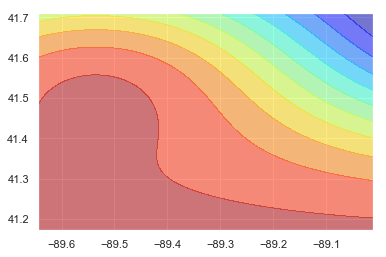

In [56]:
data_name = data_names[0]
data_pickle = data_path + data_name

#default_coord = [38.692918, -77.575285]
#default_coord = [36.442256, -110.257936]
default_coord = [41.353679, -89.735867]

scale_x = 2200000
scale_y = 280000
plot_grid(data_pickle, default_coord, scale_x, scale_y)

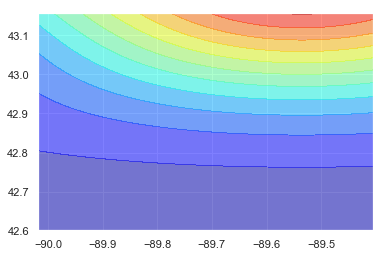

In [12]:
data_name = data_names[1]
data_pickle = data_path + data_name

#default_coord = [38.692918, -77.575285]
#default_coord = [36.442256, -110.257936]
default_coord = [41.353679, -89.735867]

scale_x = 820000
scale_y = 270000 
heat_data_2 = plot_grid(data_pickle, default_coord, scale_x, scale_y)

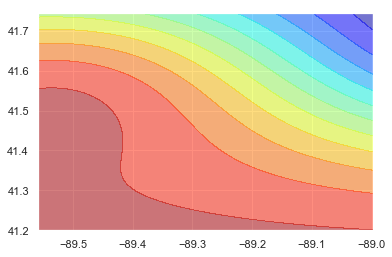

In [13]:
data_name = data_names[2]
data_pickle = data_path + data_name

#default_coord = [38.692918, -77.575285]
#default_coord = [36.442256, -110.257936]
default_coord = [41.353679, -89.735867]

scale_x = 11700000
scale_y = 3700000
heat_data_3 = plot_grid(data_pickle, default_coord, scale_x, scale_y)

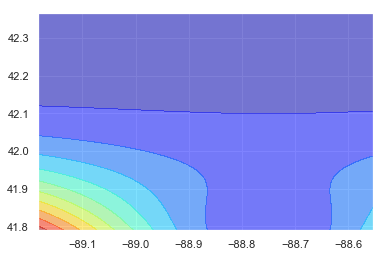

In [14]:
data_name = data_names[3]
data_pickle = data_path + data_name

#default_coord = [38.692918, -77.575285]
#default_coord = [36.442256, -110.257936]
default_coord = [41.353679, -89.735867]

scale_x = 1600000
scale_y = 12200000
heat_data_4 = plot_grid(data_pickle, default_coord, scale_x, scale_y)

In [15]:
############################################################
def scale_xy(xy_coord, scale_x, scale_y):
    
    return ( xy_coord[0]*scale_x, xy_coord[1]*scale_y)  

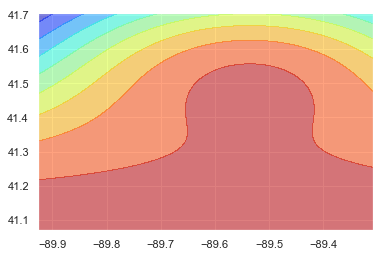

In [16]:
data_name = 'data/ckt12_ieee8500_system_data.dat'
data_path = os.getcwd() + '/'
data_pickle = data_path + data_name

#default_coord = [38.692918, -77.575285]
#default_coord = [36.442256, -110.257936]
default_coord = [41.353679, -89.735867]

scale_x = 1
scale_y = 1
    
plot_grid(data_pickle, default_coord, scale_x, scale_y)

In [31]:
file_url = 'http://www2.census.gov/geo/docs/maps-data/data/gazetteer/2016_Gazetteer/2016_Gaz_zcta_national.zip'

#Pandas usually infers zips are numerics, but we lose our leading zeroes so let's go with the object dtype
df = pd.read_csv(file_url, sep='\t', dtype={'GEOID' : object}) 

df.columns = df.columns.str.strip() #some column names have some padding
df.head()

,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,00601,166659884,799293,64.348,0.309,18.180555,-66.749961
1,00602,79287203,4448761,30.613,1.718,18.361945,-67.175597
2,00603,81884707,183895,31.616,0.071,18.455183,-67.119887
3,00606,109579998,12487,42.309,0.005,18.158345,-66.932911
4,00610,93020979,4171994,35.916,1.611,18.295366,-67.125135


In [32]:
#grab a random sample from df
subset_of_df = df.sample(n=100)

#creating a map that's centered to our sample
some_map = folium.Map(location=[subset_of_df['INTPTLAT'].mean(), 
                                subset_of_df['INTPTLONG'].mean()], 
                                zoom_start=4)

#creating a Marker for each point in df_sample.  Each point will get a popup with their zip
for row in subset_of_df.itertuples():
    some_map.add_child(folium.Marker(location=[row.INTPTLAT, row.INTPTLONG],
                                     popup=row.GEOID,
                                     icon=folium.Icon(color='green' if row.INTPTLONG > -100 else 'red', 
                                                      prefix='fa', icon='circle')))

legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 100px; height: 90px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Cool Legend <br>
                              &nbsp; East &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                              &nbsp; West &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
                </div>
                ''' 

some_map.get_root().html.add_child(folium.Element(legend_html))
some_map

<img src="popup.PNG">

## IEEE123

In [30]:
xl = pd.ExcelFile("./data/IEEE123Coordinates.xlsx")
print(xl.sheet_names)
df = xl.parse("Sheet1")
print(list(df.columns.values))

default_coord = [41.353679, -89.735867]

df.iloc[0]['latitude (y coordinates)'], df.iloc[0]['longitude  (x coordinates)']
lats = [i+ default_coord[0] for i in df['latitude (y coordinates)'].tolist()]
lons = [i+ default_coord[1] for i in df['longitude  (x coordinates)'].tolist()]
df['lat'] = lats
df['lon'] = lons
df.head()

['Sheet1']
['Node Name', 'longitude  (x coordinates)', 'latitude (y coordinates)']


,Node Name,longitude (x coordinates),latitude (y coordinates),lat,lon
0,1,0.000979,0.000058,41.353737,-89.734888
1,2,0.000921,0.000461,41.354140,-89.734946
2,3,0.000921,-0.000691,41.352988,-89.734946
3,4,0.000921,-0.000921,41.352758,-89.734946
4,5,0.001267,-0.000691,41.352988,-89.734600


In [34]:
xl = pd.ExcelFile("./data/Flood_IEEE123Coordinates.xlsx")
print(xl.sheet_names)
df = xl.parse("Sheet1")
print(list(df.columns.values))
df.head()

['Sheet1']
['Node Name', 'longitude  (x coordinates)', 'latitude (y coordinates)']


,Node Name,longitude (x coordinates),latitude (y coordinates)
0,1,-88.444121,41.743958
1,2,-88.444179,41.744361
2,3,-88.444179,41.743209
3,4,-88.444179,41.742979
4,5,-88.443833,41.743209


In [38]:
xl = pd.ExcelFile("./data/Flood_weather_metric.xlsx")
print(xl.sheet_names)
df = xl.parse("Sheet1")
print(list(df.columns.values))
df.head()

['Sheet1']
['Flood depth (ft)', 'longitude  (x coordinates)', 'latitude (y coordinates)']


,Flood depth (ft),longitude (x coordinates),latitude (y coordinates)
0,0,-88.5231,41.8039
1,1,-88.5231,41.8019
2,1,-88.5231,41.7999
3,1,-88.5231,41.7979
4,1,-88.5231,41.7959


In [36]:
xl = pd.ExcelFile("./data/Flood_damge_123.xlsx")
print(xl.sheet_names)
df = xl.parse("Line")
print(list(df.columns.values))
df.head()

['Line', 'Substation', 'PV Panel']
['Start node', 'End node', 'length', 'flood depth', 'failure probability', 'damage status']


,Start node,End node,length,flood depth,failure probability,damage status
0,1,2,175,5,0.029701,'Intact'
1,1,3,250,5,0.029701,'Intact'
2,1,7,300,5,0.029701,'Intact'
3,3,4,200,7,0.058808,'Intact'
4,3,5,325,7,0.077632,'Intact'


In [40]:
xl = pd.ExcelFile("./data/Winter_Storm_damge_123.xlsx")
print(xl.sheet_names)
df = xl.parse("Line")
print(list(df.columns.values))
df.head()

['Line', 'Substation', 'PV Panel']
['Start node', 'End node', 'length', 'ice thickness', 'wind speed', 'failure probability', 'damage status']


,Start node,End node,length,ice thickness,wind speed,failure probability,damage status
0,1,2,175,0.0,129.741962,0.977654,'Damaged'
1,1,3,250,0.0,129.741962,0.977654,'Damaged'
2,1,7,300,0.0,129.741962,0.977654,'Damaged'
3,3,4,200,0.0,129.741962,0.977654,'Damaged'
4,3,5,325,0.0,129.741962,0.993706,'Damaged'


In [42]:
xl = pd.ExcelFile("./data/Winter_Storm_Ice_weather_metric.xlsx")
print(xl.sheet_names)
df = xl.parse("Sheet1")
print(list(df.columns.values))
df.head()

['Sheet1']
['Ice Thickness (inch)', 'longitude  (x coordinates)', 'latitude (y coordinates)']


,Ice Thickness (inch),longitude (x coordinates),latitude (y coordinates)
0,0.0,-88.5231,41.8159
1,0.0,-88.5231,41.8139
2,0.0,-88.5231,41.8119
3,0.0,-88.5231,41.8099
4,0.0,-88.5231,41.8079


In [44]:
xl = pd.ExcelFile("./data/Winter_Storm_IEEE123Coordinates.xlsx")
print(xl.sheet_names)
df = xl.parse("Sheet1")
print(list(df.columns.values))
df.head()

['Sheet1']
['Node Name', 'longitude  (x coordinates)', 'latitude (y coordinates)']


,Node Name,longitude (x coordinates),latitude (y coordinates)
0,1,-88.444121,41.747058
1,2,-88.444179,41.747461
2,3,-88.444179,41.746309
3,4,-88.444179,41.746079
4,5,-88.443833,41.746309


In [45]:
xl = pd.ExcelFile("./data/Winter_Storm_Wind_weather_metric.xlsx")
print(xl.sheet_names)
df = xl.parse("Sheet1")
print(list(df.columns.values))
df.head()

['Sheet1']
['Wind Speed (mph)', 'longitude  (x coordinates)', 'latitude (y coordinates)']


,Wind Speed (mph),longitude (x coordinates),latitude (y coordinates)
0,122.640302,-88.5231,41.8159
1,123.212139,-88.5231,41.8139
2,123.775779,-88.5231,41.8119
3,124.331132,-88.5231,41.8099
4,124.878125,-88.5231,41.8079


In [32]:
df_line_IEEE123 = pd.read_pickle('./data/df_line_IEEE123.pkl')
df_node_IEEE123 = pd.read_pickle('./data/df_node_IEEE123.pkl')
#df_node_IEEE123.head()
#df_line_IEEE123.head()

,Node A,Node B,Length (ft.),Config.,control,status,outage,Node_A_coord,Node_B_coord,Node_AB_coord,FI_Installation,FI_Direction,Fault Indicator Status,FI Prob,Weather Prob,FI+Weather Prob,FI_Prob_color,Weather_Prob_color,FI+Weather_Prob_color
0,1,2,175,10,False,False,False,"(41.728412092768686, -72.72210804775935)","(41.730933127316824, -72.72258827842913)","((41.728412092768686, -72.72210804775935), (41...",1,0,0,0.00,0.404715,0.404715,#00FF00,#FCB07A,#FCB07A
1,1,3,250,11,False,False,False,"(41.728412092768686, -72.72210804775935)","(41.72373033230179, -72.72258978193973)","((41.728412092768686, -72.72210804775935), (41...",1,1,1,0.25,0.523373,0.642530,#FDD39D,#F98656,#EB5D42
2,1,7,300,1,False,False,False,"(41.728412092768686, -72.72210804775935)","(41.728771915647876, -72.71970417168718)","((41.728412092768686, -72.72210804775935), (41...",1,1,1,0.00,0.555533,0.555533,#00FF00,#F67A51,#F67A51
3,3,4,200,11,False,False,False,"(41.72373033230179, -72.72258978193973)","(41.72228977221158, -72.72259008257612)","((41.72373033230179, -72.72258978193973), (41....",0,0,N/A,0.25,0.447232,0.585424,#FDD39D,#FCA06B,#F3724D
4,3,5,325,11,False,False,True,"(41.72373033230179, -72.72258978193973)","(41.723729958251866, -72.71970544960132)","((41.72373033230179, -72.72258978193973), (41....",0,0,N/A,0.25,0.584574,0.688431,#FDD39D,#F3724D,#E24932


# Large system

## I. Data preprocessing for large system

In [8]:
xl = pd.ExcelFile("./data/Flood_weather_metric.xlsx")
print(xl.sheet_names)
df_flood = xl.parse("Sheet1")
df_flood.head()

['Sheet1']


,Flood depth (ft),longitude (x coordinates),latitude (y coordinates)
0,0,-88.5231,41.8039
1,1,-88.5231,41.8019
2,1,-88.5231,41.7999
3,1,-88.5231,41.7979
4,1,-88.5231,41.7959


In [9]:
data_name = 'data/ckt12_ieee8500_system_data.dat'
data_path = os.getcwd() + '/'
data_pickle = data_path + data_name

##################################################################################
_, _, _, _, _, _, _, nodes, edges  = extract_networks(data_pickle)
df_node = pd.DataFrame.from_dict(nodes, orient='index')
df_node.reset_index(level=0, inplace=True)
df_node.rename(columns={'index': 'Node', 0: 'lon',  1: 'lat'}, inplace=True)

df_node['lon'] = df_node['lon'].apply(lambda i: i/364647.0 -88.4700)
df_node['lat'] = df_node['lat'].apply(lambda i: i/364647.0 +41.7470)
df_node = df_node[['Node','lat','lon']]
df_node.head()
#[X,Y]/364647 +[-88.4700, 41.7470]


##################################################################################
default_coord = [41.353679, -89.735867]
scale_x = 1
scale_y = 1
    
_, df_line, centroid_coord = generate_dataframe(data_pickle, default_coord, scale_x, scale_y)

df_line.drop(['Node_A_coord', 'Node_B_coord', 'Node_AB_coord'], axis=1, inplace=True)
df_line = find_geometry_points(df_node, df_line)
#df_line['Node A'].unique(), df_line['Node B'].unique()
df_line.head()

,Node A,Node B,Node_A_coord,Node_B_coord,Node_AB_coord
0,157345,157346,"(41.743181238293474, -88.46848483601948)","(41.74300983965314, -88.46845741223704)","((41.743181238293474, -88.46848483601948), (41..."
1,165442,298160,"(41.74238594860235, -88.4681283268476)","(41.73753193910823, -88.46903331166854)","((41.74238594860235, -88.4681283268476), (41.7..."
2,165448,275354,"(41.73277391285271, -88.46896475221241)","(41.72581512805535, -88.46797749604411)","((41.73277391285271, -88.46896475221241), (41...."
3,165449,165450,"(41.72525294051508, -88.46802548766341)","(41.72477988026777, -88.46873850600718)","((41.72525294051508, -88.46802548766341), (41...."
4,165453,165454,"(41.72355266600301, -88.46888933681066)","(41.72362122545914, -88.46941038867726)","((41.72355266600301, -88.46888933681066), (41...."


## II. Flood data for large system

In [10]:
xl = pd.ExcelFile("./data/Flood_damge_128500.xlsx")
print(xl.sheet_names)

['Line', 'Substation', 'PV Panel']


### 1. Wrangling line

In [11]:
df_flood_line = xl.parse("Line")
rm_quote = lambda x: x.replace("\'", "")
#df_flood_line['Start node'] = df_flood_line['Start node'].apply(lambda s: s.replace("\'" ,""))
df_flood_line['Start node'] = df_flood_line['Start node'].apply(rm_quote)
df_flood_line['End node'] = df_flood_line['End node'].apply(rm_quote)
df_flood_line['damage status'] = df_flood_line['damage status'].apply(rm_quote)
print(list(df_flood_line.columns.values))
df_flood_line.rename(columns={'Start node': 'Node A', 'End node': 'Node B'}, inplace=True)
df_flood_line.head()

['Start node', 'End node', 'length', 'flood depth', 'failure probability', 'damage status']


,Node A,Node B,length,flood depth,failure probability,damage status
0,157345,157346,25.329415,3,0.019900,Intact
1,165442,298160,746.725743,3,0.058520,Intact
2,165448,275354,1067.706957,6,0.086483,Damaged
3,165449,165450,167.561293,6,0.029701,Intact
4,165453,165454,76.644455,5,0.019900,Intact


In [12]:
df_flood_line = find_geometry_points(df_node, df_flood_line)
df_flood_line.head()

,Node A,Node B,length,flood depth,failure probability,damage status,Node_A_coord,Node_B_coord,Node_AB_coord
0,157345,157346,25.329415,3,0.019900,Intact,"(41.743181238293474, -88.46848483601948)","(41.74300983965314, -88.46845741223704)","((41.743181238293474, -88.46848483601948), (41..."
1,165442,298160,746.725743,3,0.058520,Intact,"(41.74238594860235, -88.4681283268476)","(41.73753193910823, -88.46903331166854)","((41.74238594860235, -88.4681283268476), (41.7..."
2,165448,275354,1067.706957,6,0.086483,Damaged,"(41.73277391285271, -88.46896475221241)","(41.72581512805535, -88.46797749604411)","((41.73277391285271, -88.46896475221241), (41...."
3,165449,165450,167.561293,6,0.029701,Intact,"(41.72525294051508, -88.46802548766341)","(41.72477988026777, -88.46873850600718)","((41.72525294051508, -88.46802548766341), (41...."
4,165453,165454,76.644455,5,0.019900,Intact,"(41.72355266600301, -88.46888933681066)","(41.72362122545914, -88.46941038867726)","((41.72355266600301, -88.46888933681066), (41...."


In [13]:
discrete_probability = lambda x : 1 if x =='Damaged' else 0
a = df_flood_line['damage status'].apply(discrete_probability)
print(len([i for i in a if i == 0]))
print(len([i for i in a if i == 1]))
list(df_flood_line.columns.values)

3546
127


['Node A',
 'Node B',
 'length',
 'flood depth',
 'failure probability',
 'damage status',
 'Node_A_coord',
 'Node_B_coord',
 'Node_AB_coord']

In [14]:
print(len(df_flood_line))
print(len(df_flood_line[df_flood_line['damage status'] == 'Intact']['damage status'] ))
print(len(df_flood_line[df_flood_line['damage status'] == 'Damaged']['damage status'] ))

3673
3546
127


### 2. Wrangling Substation and PV Panel (nodes)

In [15]:
df_flood_substation_node = xl.parse("Substation")
rm_quote = lambda x: x.replace("\'", "")
df_flood_substation_node['damage status'] = df_flood_substation_node['damage status'].apply(rm_quote)
df_flood_substation_node['node'] = df_flood_substation_node['node'].astype(str)
df_flood_substation_node.rename(columns={'node': 'Node'}, inplace=True)
df_flood_substation_node.head()

,Node,flood depth,failure probability,damage status
0,318412,3,0.06,Substation Intact


In [16]:
df_flood_substation_node = df_flood_substation_node.merge(df_node, how='left', on='Node') 
df_flood_substation_node

,Node,flood depth,failure probability,damage status,lat,lon
0,318412,3,0.06,Substation Intact,41.747,-88.47


In [17]:
df_flood_pv_node = xl.parse("PV Panel")
rm_quote = lambda x: x.replace("\'", "")
df_flood_pv_node['damage status'] = df_flood_pv_node['damage status'].apply(rm_quote)
df_flood_pv_node['node'] = df_flood_pv_node['node'].apply(rm_quote)
df_flood_pv_node['node'] = df_flood_pv_node['node'].astype(str)
df_flood_pv_node.rename(columns={'node': 'Node'}, inplace=True)
#df_flood_pv_node

In [18]:
df_flood_pv_node = df_flood_pv_node.merge(df_node, how='left', on='Node') 
#df_flood_pv_node

In [19]:
#df_node = df_node.merge(df_flood_pv_node, how='left', left_on='Node', right_on='node')
df_flood_substation_pv_node = df_flood_pv_node.append(df_flood_substation_node, ignore_index=True)
#df_flood_substation_pv_node

## III. Modified plot grid function

In [49]:
############################################################
def df_to_html(row, info_name = None):
    
    #style = '<style> #myDIV { width: 360px;height: 50px;background-color: #FF7006;color: white;text-align:center;font-family:courier;font-size:10px;} </style> <div id="myDIV"> <h1>' + str(info_name) + '</h1> </div>' 
    style = '<style> #myDIV { width: 360px;height: 50px;background-color: #99bbff;color: white;text-align:center;font-family:courier;font-size:10px;} </style> <div id="myDIV"> <h1>' + str(info_name) + '</h1> </div>' 
    newdf = pd.DataFrame(row).copy(deep=True)

    html = newdf.to_html()
    html = html.replace('\n', ' ')
    html = html.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html =  style + html


    #remove content between <thead>  </thead>
    pattern = r'.*?\<thead>(.*)\</thead>.*'
    match = re.search(pattern, html)
    header = match.group(1)
    html = html.replace(header,'')


    #replace <tr> with <tr style="text-align: left;">
    html = html.replace('<tr>','<tr style="text-align: left;">')
    return html


############################################################
def generate_baseMap(default_location=[40.5397293,-74.6273494], default_zoom_start=12, default_tile='openstreetmap'):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start, tiles=default_tile)
    return base_map



############################################################
from folium import IFrame

##Create folium polyline layer
#make folium polyline for each edge in df_edge
def generate_folium_polyline(edge, attr, edge_width, edge_opacity=0.15, info_name = None):
    """
    Turn a row from the gdf_edges GeoDataFrame into a folium PolyLine 
    Parameters
    ----------
    edge : GeoSeries
        a row from the gdf_edges GeoDataFrame
    edge_width : numeric
        width of the edge lines
    edge_opacity : numeric
        opacity of the edge lines
    Returns
    -------
    pl : folium.PolyLine
    """
    locations = [(coord[0], coord[1]) for coord in edge['Node_AB_coord']]
    
    #edge color
    edge_color = '#339FFF'
    #edge_color = '#00FFFF'
    #edge_color = '#00FF7F' # green color
    #edge_color = '8A837B' # brown color
    #edge_color = 'EFFA07'
    
    row = edge[attr]
    html = df_to_html(row, info_name = info_name)
    iframe = IFrame(html=html, width=360, height=240)
    popup = folium.Popup(iframe, max_width=2650)
    
    
    # create a folium polyline with attributes
    #pl = folium.PolyLine(locations=locations, popup=popup, color=edge_color, weight=edge_width, opacity=edge_opacity)
    pl = folium.PolyLine(locations=locations, color=edge_color, weight=edge_width, opacity=edge_opacity)
    return pl



############################################################
#create folium polyline layer
def add_polyline(mapobj, df, attr = [], layer_name = None,  info_name = None):
    """
    Add the layer of folium polylines from edges GeoDataFrame
    Parameters
    ----------
    mapobj : Folium map object
        Folium map object
    gdf_edges : GeoDataFrame
        edges GeoDataFrame
    Returns
    -------
    layer of folium polylines
    """
    
    #polyline_layer = folium.FeatureGroup(name = str(layer_name), overlay=False)
    polyline_layer = folium.FeatureGroup(name = str(layer_name))
    
    for _, row in df.iterrows():
        #pl = generate_folium_polyline(row, attr, edge_width=row['probability'], edge_opacity=3, prob_name=prob_name, info_name = info_name)
        pl = generate_folium_polyline(row, attr, edge_width=5, edge_opacity=3, info_name = info_name)
        pl.add_to(polyline_layer)

    polyline_layer.add_to(mapobj)
    
    return mapobj



                                                                                                                   
############################################################
#create heatmap data layer
def generate_heat_data(df_line, heatmap_attr = None):
    n = len(df_line)
  
    center_point = [(np.mean([pair_node[0][0], pair_node[1][0]]), 
                     np.mean([pair_node[0][1], pair_node[1][1]]) ) for pair_node in df_line['Node_AB_coord'].tolist()]
    
    df_heat_map = pd.DataFrame(center_point, columns=['lat', 'lon'])
    df_heat_map = pd.concat([df_heat_map, df_line], axis=1)
    df_heat_map.rename(columns={'Node A': 'Start Node', 'Node B': 'End Node'}, inplace=True)
    
    if  heatmap_attr == 'failure probability':
        df_heat_map['probability'] = df_line['failure probability']
    if heatmap_attr == 'damage status':
        df_heat_map['probability'] = df_line['damage status'].apply(lambda x : 1 if x =='Damaged' else 0)

    #heat_data = df_new.as_matrix()
    heat_data = df_heat_map[['lat', 'lon', 'probability']].values.tolist()
    return heat_data,  df_heat_map




############################################################
#create heatmap layer
def add_heatmap(mapobj, df_line, attr=[], radius=20, heat_name=None, info_name=None, colors=None, caption=None, colormap=None, heatmap_attr=None):

    heatmap_layer = folium.FeatureGroup(name = str(heat_name))
    
    heat_data, df_heat_map = generate_heat_data(df_line, heatmap_attr)
    

    vmin   = np.min(df_heat_map['probability'])
    vmax   = np.max(df_heat_map['probability'])
    cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax, caption = caption)
   
    tooltip = '<i>Click here</i>'


         
    for _, row in df_heat_map.iterrows(): 
        row = row[attr]
    
        html = df_to_html(row[[x for x in attr if x not in set(['lat', 'lon'])]], info_name = info_name)
        iframe = IFrame(html=html, width=360, height=200)
        popup = folium.Popup(iframe, max_width=2650)
        
        #fill_color='#FFFFFF',
        folium.Circle(np.array([row['lat'], row['lon'] ]), 
                      radius=10,
                      popup=popup,
                      fill=True, 
                      opacity = 0.005, 
                      stroke = False,
                      tooltip = tooltip,
                      color = '#FFFFFF').add_to(heatmap_layer)
        heatmap_layer.add_to(mapobj)

    
    HeatMap(heat_data, 
            name = heat_name, 
            radius = radius, 
            gradient = colormap, 
            min_opacity=0.2,
            max_val=float(df_heat_map['probability'].max()),
            blur=15,
            max_zoom=1).add_to(folium.FeatureGroup(name = str(heat_name)).add_to(mapobj))
           
    mapobj.add_child(cm)
        
    #heatmap_layer.add_to(folium.FeatureGroup(name = str(heat_name)).add_to(mapobj))
    #mapobj.add_child(folium.ClickForMarker(popup='Potential Location'))  
    
    return mapobj




####################################################################################
#create point cluster layer
def add_point_clusters(mapobj, df_node, attr = [], node_icon = None, node_name = None, icon_size=(15, 15), info_name = None):
    """
    Add the layer of point locations from edges GeoDataFrame
    Parameters
    ----------
    mapobj : map object
        Folium map object
    gdf_nodes : GeoDataFrame
        nodes GeoDataFrame
    Returns
    -------
    layer of point locations
    """      

    #point_layer = folium.FeatureGroup(name = node_name, overlay=False)
    point_layer = folium.FeatureGroup(name = node_name)

    for _, row in df_node.iterrows(): 
        
        row = row[attr]
         
        html = df_to_html(row[[x for x in attr if x not in set(['lat', 'lon'])]], info_name = info_name)
        iframe = IFrame(html=html, width=360, height=200)
        popup = folium.Popup(iframe, max_width=2650)
        
        if row['damage status'] == 'Substation Intact':
            icon_url = 'https://raw.githubusercontent.com/dvu4/grid_folium/master/data/r_diamond.png'
            icon = folium.features.CustomIcon(icon_url, icon_size=icon_size) #(30, 30)
            
            # extract lat and long coordinates to assign to the marker
            folium.Marker(np.array([row['lat'], row['lon']]), popup=popup, icon=icon).add_to(point_layer)
        else :
            icon_url = 'https://raw.githubusercontent.com/dvu4/grid_folium/master/data/g-diamond.png'
            icon = folium.features.CustomIcon(icon_url, icon_size=icon_size)
            
            # extract lat and long coordinates to assign to the marker
            folium.Marker(np.array([row['lat'], row['lon']]), popup=popup, icon=icon).add_to(point_layer)
        
    
        #FastMarkerCluster(np.array([row.lat, row.lon]), popup=popup, icon=icon).add_to(point_layer)
    #Create a Folium feature group for this layer, since we will be displaying multiple layers
    point_layer.add_to(mapobj)
    
    
    legend_html =   '''
                 <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 110px; height: 75px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            "><br>
                              &nbsp; Substation &nbsp; <img src='https://raw.githubusercontent.com/dvu4/grid_folium/master/data/r_diamond.png' alt="Smiley face" width="18" height="18" align="right"><br>
                              &nbsp; PV Panel   &nbsp; <img src='https://raw.githubusercontent.com/dvu4/grid_folium/master/data/g-diamond.png' alt="Smiley face" width="18" height="18" align="right">
                 </div>
                                       
                ''' 

    
    
    
    mapobj.get_root().html.add_child(folium.Element(legend_html))
    
    return mapobj


####################################################################################
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage

def generate_legend_property(geojson):
    unique_titles = []
    for i in geojson['features']:
        n = round(float(i['properties']['title']), 2)
        unique_titles.append(n)
        unique_titles = sorted(list(set(unique_titles)), reverse=True)

    properties_dict = {str(i): str(x) for i,x in enumerate(unique_titles)}
    return properties_dict

####################################################################################
#create GeoJSON and TopoJSON layers 
def generate_contour(mapobj, centroid_coord, nb_class = 10, contour_name = None, df_flood = None):
    
    # Setup colormap
    #colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
    #levels = len(colors)
    #cm     = branca.colormap.LinearColormap(colors, vmin=0, vmax=1).to_step(levels)
    #cm     = branca.colormap.LinearColormap(['b','c','g','y','r'], vmin=0, vmax=1)
    cm     = branca.colormap.LinearColormap(['#0000FF', '#6495ED', '#00FFFF', '#008000', '#8FBC8F', '#FFFF00', '#FFA500', '#FFA07A', '#FF6347', '#FF0000'], 
                                            vmin=1, 
                                            vmax=10, 
                                            caption = contour_name)  
    
    if df_flood is not None:

        # The original data
        x_orig = np.asarray(df_flood['longitude  (x coordinates)'].tolist())
        y_orig = np.asarray(df_flood['latitude (y coordinates)'].tolist())
        z_orig = np.asarray(df_flood['Flood depth (ft)'].tolist())
 
        # Make a grid
        x_arr          = np.linspace(-88.5231, -88.3651, 80)
        y_arr          = np.linspace(41.6859,  41.8039,  60)
        x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
    
        # Grid the values
        #z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='nearest')
        z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
        #z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='cubic')
        #z_mesh = np.random.rand(60,80) 
        
        # Gaussian filter the grid to make it smoother
        sigma = [5, 5]
        z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')


    
    else:
        # Create a dataframe with fake data
        df = pd.DataFrame({
            'longitude':   np.random.normal(centroid_coord[1],    0.075,     10000),
            'latitude':    np.random.normal(centroid_coord[0],    0.075,     10000),
            'probability': [random.randint(1,10) for i in range(10000)]
            #'probability': np.random.normal(0, 1, 10000)})
        })
            

        # The original data
        x_orig = np.asarray(df.longitude.tolist())
        y_orig = np.asarray(df.latitude.tolist())
        z_orig = np.asarray(df.probability.tolist())
 
        # Make a grid
        x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 1000)
        y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 1000)
        x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 
        wave = 0.75*(np.sin(2.*y_mesh)**8*np.cos(4.*x_mesh))
        mean = 0.5*np.cos(2.*y_mesh)*((np.sin(2.*y_mesh))**2 + 2.)
        z_mesh = wave + mean
     
        
    # Create the contour
    #contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors)
    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, nb_class, alpha=0.5, cmap=plt.cm.jet)
 
    # Convert matplotlib contourf to geojson
    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=0.5)
    
    '''
    #A Python dictionary containing properties to be added to each GeoJSON Feature
    properties_dict={'0.80 ' : '10',
                     '0.60 ' : '9',
                     '0.40 ' : '8',
                     '0.20 ' : '7',
                     '0.00 ' : '6',
                     '-0.20 ': '5',
                     '-0.40 ': '4',
                     '-0.60 ': '3', 
                     '-0.80 ': '2',
                     '-1.00 ': '1'}
    
    
    
    # The JSON was encoded twice (WEIRD !!!)
    geojson = json.loads(geojson) 

    properties_dict = generate_legend_property(geojson)
    
    #Loop over GeoJSON features and add the new properties       
    for feat in geojson['features']:
        #print(feat['properties']['title'])
        if feat['properties']['title'] in properties_dict.keys():
            key_match = feat['properties']['title'] 
            feat['properties']['flood depth'] = properties_dict[key_match]
    
    

    # Plot the contour plot on folium
    folium.GeoJson(
            geojson,
            name = contour_name,
            style_function=lambda x: {
                'color':     x['properties']['stroke'],
                'weight':    x['properties']['stroke-width'],
                'fillColor': x['properties']['fill'],
                'opacity':   0.6},
            tooltip=folium.GeoJsonTooltip(fields=['title'],
                                      aliases=['<div style="background-color: lightyellow; color: black; padding: 3px; border: 2px solid black; border-radius: 3px;">'+item+'</div>' for item in ['title']],
                                      style="font-family: san serif;",
                                      localize=True)).add_to(mapobj)
 
    '''
    
    
    # Plot the contour plot on folium
    folium.GeoJson(
            geojson,
            name = contour_name,
            style_function=lambda x: {
                'color':     x['properties']['stroke'],
                'weight':    x['properties']['stroke-width'],
                'fillColor': x['properties']['fill'],
                'opacity':   0.6}).add_to(mapobj)    
    
    # Add the colormap to the folium map
    mapobj.add_child(cm) 
    
    return mapobj


####################################################################################
#plot map
from folium import IFrame

def plot_grid(data_pickle, default_coord, df_node, df_line, df_flood, df_flood_substation_pv_node):

    name = data_pickle.split('/')[-1].split('.')[0]
    centroid_coord = [ df_node['lat'].mean(), df_node['lon'].mean() ]
    
    folium_map = generate_baseMap(default_location=centroid_coord)

    
    
    #Update basemap with GeoJSON Layer
    folium_map = generate_contour(folium_map, 
                                 centroid_coord, 
                                 contour_name = 'Weather distribution',
                                 df_flood = df_flood)    
    

    
    
    #Update basemap with Polyline Layer
    folium_map = add_polyline(folium_map, 
                             df_line, 
                             attr = ['Node A', 'Node B'],
                             layer_name = 'Grid',
                             info_name = 'Line Information')


    
    #Update basemap with point cluster layer
    folium_map = add_point_clusters(folium_map, 
                                   df_flood_substation_pv_node, 
                                   attr = ['Node', 'flood depth', 'failure probability', 'damage status', 'lat', 'lon'],  
                                   node_name = 'Substation & PV Panel',
                                   icon_size=(24, 24),
                                   info_name = 'Detail of Electric Component')
    
    
    
    


    
    #Update basemap with heatmap Layer    
    colors = ['b','c','g','y','r']
    caption = 'Failure Probability'
    colormap = {0.0: 'blue', 0.3:'coral', 0.5: 'green', 0.7: 'yellow', 1.0: 'red'}
    heatmap_attr = 'failure probability'

    folium_map = add_heatmap(folium_map, 
                 df_line, 
                 attr=['lat', 'lon', 'Start Node', 'End Node', 'length', 'flood depth', 'failure probability', 'damage status'], 
                 radius=20, 
                 heat_name=caption , 
                 info_name=caption , 
                 colors=colors, 
                 caption=caption, 
                 colormap=colormap, 
                 heatmap_attr=heatmap_attr)
    
  
    colors_ds = ['black','orange','r']
    caption_ds = 'Damage Status'
    colormap_ds = {0.0: '#000000', 0.5: '#8b0000', 1.0: '#d80000'}
    heatmap_attr_ds = 'damage status'

    folium_map = add_heatmap(folium_map, 
                 df_line, 
                 attr=['lat', 'lon', 'Start Node', 'End Node', 'length', 'flood depth', 'failure probability', 'damage status'], 
                 radius=20, 
                 heat_name=caption_ds, 
                 info_name='Detail of Electric Component', 
                 colors=colors_ds, 
                 caption=caption_ds, 
                 colormap=colormap_ds, 
                 heatmap_attr=heatmap_attr_ds)  

    
 
    folium.TileLayer('stamentoner').add_to(folium_map)
    folium.TileLayer('stamenwatercolor').add_to(folium_map)
    folium.TileLayer('Stamen Terrain').add_to(folium_map)
    folium.TileLayer('cartodbdark_matter').add_to(folium_map)
    folium.TileLayer('cartodbpositron').add_to(folium_map)

    
    # Fullscreen
    plugins.Fullscreen(position='topright',
                       title='Expand me',
                       title_cancel='Exit me',
                       force_separate_button=True).add_to(folium_map)


    folium_map.add_child(folium.LayerControl(collapsed=True)) #Add layer control to toggle on/off
    #gfolium_map.get_root().add_child(folium.LayerControl())
    #folium.LayerControl().add_to(folium_map)
    
    
    filepath = os.getcwd() + '/' + name + '.html'    
    folium_map.save(filepath)
    
    IFrame(filepath, width=600, height=500) #display map

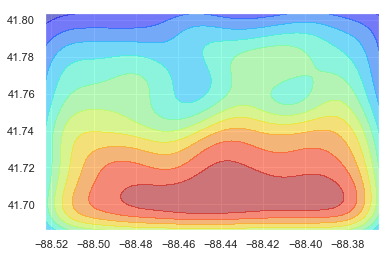

In [50]:
plot_grid(data_pickle, default_coord, df_node, df_flood_line, df_flood, df_flood_substation_pv_node)

In [44]:
xl = pd.ExcelFile("./data/Winter_Storm_damge_128500.xlsx")
print(xl.sheet_names)

['Line', 'Substation', 'PV Panel']


In [45]:
df_storm_line = xl.parse("Line")
rm_quote = lambda x: x.replace("\'", "")
#df_flood_line['Start node'] = df_flood_line['Start node'].apply(lambda s: s.replace("\'" ,""))
df_storm_line['Start node'] = df_storm_line['Start node'].apply(rm_quote)
df_storm_line['End node'] = df_storm_line['End node'].apply(rm_quote)
df_storm_line['damage status'] = df_storm_line['damage status'].apply(rm_quote)
print(list(df_storm_line.columns.values))
df_storm_line.rename(columns={'Start node': 'Node A', 'End node': 'Node B'}, inplace=True)
df_storm_line.head()

['Start node', 'End node', 'length', 'ice thickness', 'wind speed', 'failure probability', 'damage status']


,Node A,Node B,length,ice thickness,wind speed,failure probability,damage status
0,157345,157346,25.329415,0.25,128.280536,0.999970,Damaged
1,165442,298160,746.725743,0.25,128.280536,1.000000,Damaged
2,165448,275354,1067.706957,0.25,125.600875,1.000000,Damaged
3,165449,165450,167.561293,0.50,123.496180,1.000000,Damaged
4,165453,165454,76.644455,0.25,122.975375,0.999801,Damaged


### IEEE123

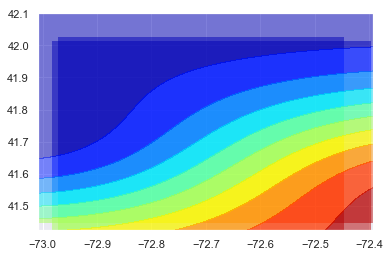

In [28]:
def generate_heat_data_IEEE123(df_line, attr = None):
    middle_point = [(np.mean([node[0][0], node[1][0]]), np.mean([node[0][1], node[1][1]]) )  for node in df_line['Node_AB_coord'].tolist()]
    df_new = pd.DataFrame(middle_point, columns=['lat', 'lon'])
    df_new['probability'] = df_line[attr]
    
    #heat_data = df_new.as_matrix()
    heat_data = df_new.values
    
    return heat_data


def plot_grid_IEEE123(attr = None):
   
    name = 'IEEE123'

    centroid_coord = [ df_node_IEEE123['lat'].mean(), df_node_IEEE123['lon'].mean() ]
    
    heat_data = generate_heat_data_IEEE123(df_line_IEEE123, attr = attr)


    

    
    graph_map = generate_baseMap(default_location=centroid_coord)
    
    
    graph_map = generate_contour(graph_map, 
                                 centroid_coord, 
                                 contour_name = 'Weather metric distribution')
        
        
    #Update basemap with Polyline Layer
    graph_map = add_polyline(graph_map, 
                             df_line_IEEE123, 
                             attr = ['Node A', 'Node B'],
                             layer_name = 'Grid '+ name,
                             info_name = 'Line Information')



    
    
    node_icon = 'https://raw.githubusercontent.com/dvu4/grid_folium/master/data/Blue_icon.png'

    #Update basemap with point cluster layer
    graph_map = add_point_clusters(graph_map, 
                                   df_node_IEEE123, 
                                   attr = ['Node', 'lat', 'lon'], 
                                   node_image = node_icon, 
                                   node_name = 'Node '+ name,
                                   info_name = 'Node Information')
    
       
    #Update heatmap 
    graph_map = add_heatmap(graph_map, 
                            df_line_IEEE123, 
                            attr = ['lat', 'lon', 'probability'], 
                            radius = 10, 
                            heat_name = 'Probability failure for ' + name,
                            info_name = 'Failure Probability',
                            discrete_layer=False)

    
    graph_map = add_heatmap(graph_map, 
                            df_line_IEEE123, 
                            attr = ['lat', 'lon', 'discrete_probability'], 
                            radius = 10, 
                            heat_name = 'Damage status ' + name,
                            info_name = 'Electric Component',
                            discrete_layer=True)
    
    
    
    folium.TileLayer('stamentoner').add_to(graph_map)
    folium.TileLayer('stamenwatercolor').add_to(graph_map)
    folium.TileLayer('Stamen Terrain').add_to(graph_map)
    folium.TileLayer('cartodbdark_matter').add_to(graph_map)
    folium.TileLayer('cartodbpositron').add_to(graph_map)
    
    # Fullscreen
    plugins.Fullscreen(position='topright',
                       title='Expand me',
                       title_cancel='Exit me',
                       force_separate_button=True).add_to(graph_map)


    graph_map.add_child(folium.LayerControl()) #Add layer control to toggle on/off

    filepath = os.getcwd() + '/' +  attr + name + '.html'    
    graph_map.save(filepath)    
    IFrame(filepath, width=600, height=500) #display map
       
plot_grid_IEEE123(attr = 'FI Prob')
plot_grid_IEEE123(attr = 'Weather Prob')
plot_grid_IEEE123(attr = 'FI+Weather Prob')

In [16]:
import numpy as np
import matplotlib.pyplot as plt


data = np.genfromtxt('temp.csv', delimiter=',')

#x = data[:1]
#y = data[:2]
#[x,y] = np.meshgrid(x,y);
#z = data[:3];

#plt.contour(x,y,z)
#plt.show()

print(data[0])
data[0][1], data[0][2], data[0][4]

[         nan  41.52848746 -89.49358211   4.6484375   19.8046875 ]


(41.5284874571595, -89.49358210563591, 19.8046875)

/Users/ducvu/anaconda3/envs/map-gen/lib/python3.6/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.


,RGBA,geometry
0,#F7D5Be,"(POLYGON ((51.56321499130653 17.529041667, 51...."
1,#F8D8C2,"(POLYGON ((51.56321480705025 17.529041667, 51...."
2,#F8DaC4,"(POLYGON ((51.56321462279397 17.529041667, 51...."
3,#F8DbC6,"(POLYGON ((51.56321443853769 17.529041667, 51...."
4,#F8DdC9,"(POLYGON ((51.56321407002513 17.529041667, 51...."
5,#F8DeCb,"(POLYGON ((51.56321388576885 17.529041667, 51...."
6,#F8E0Cd,"(POLYGON ((51.56321370151257 17.529041667, 51...."
7,#F9E1Cf,(POLYGON ((51.56321370151257 17.52904167076077...
8,#F9E3D1,"(POLYGON ((51.56321757089447 17.529041667, 51...."
9,#F9E4D3,"(POLYGON ((51.56321793940703 17.529041667, 51...."


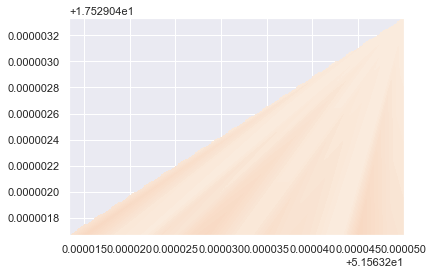

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from matplotlib.mlab import griddata
from shapely.geometry import Polygon, MultiPolygon

def convert_to_hex(rgba_color) :
    red = str(hex(int(rgba_color[0]*255)))[2:].capitalize()
    green = str(hex(int(rgba_color[1]*255)))[2:].capitalize()
    blue = str(hex(int(rgba_color[2]*255)))[2:].capitalize()

    if blue=='0':
        blue = '00'
    if red=='0':
        red = '00'
    if green=='0':
        green='00'

    return '#'+ red + green + blue

def collec_to_gdf(collec_poly):
    """Transform a `matplotlib.contour.QuadContourSet` to a GeoDataFrame"""
    polygons, colors = [], []
    for i, polygon in enumerate(collec_poly.collections):
        mpoly = []
        for path in polygon.get_paths():
            try:
                path.should_simplify = False
                poly = path.to_polygons()
                # Each polygon should contain an exterior ring + maybe hole(s):
                exterior, holes = [], []
                if len(poly) > 0 and len(poly[0]) > 3:
                    # The first of the list is the exterior ring :
                    exterior = poly[0]
                    # Other(s) are hole(s):
                    if len(poly) > 1:
                        holes = [h for h in poly[1:] if len(h) > 3]
                mpoly.append(Polygon(exterior, holes))
            except:
                print('Warning: Geometry error when making polygon #{}'
                      .format(i))
        if len(mpoly) > 1:
            mpoly = MultiPolygon(mpoly)
            polygons.append(mpoly)
            colors.append(polygon.get_facecolor().tolist()[0])
        elif len(mpoly) == 1:
            polygons.append(mpoly[0])
            colors.append(polygon.get_facecolor().tolist()[0])
    return GeoDataFrame(
        geometry=polygons,
        data={'RGBA': colors},
        crs={'init': 'epsg:4326'})


data = np.genfromtxt('temp copy.csv', delimiter=',')
x = data[..., 1]
y = data[..., 2]
z = data[..., 3]
xi = np.linspace(x.min(), x.max(), 200)
yi = np.linspace(y.min(), y.max(), 200)
zi = griddata(x, y, z, xi, yi, interp='linear') # You could also take a look to scipy.interpolate.griddata

nb_class = 15 # Set the number of class for contour creation
# The class can also be defined by their limits like [0, 122, 333]
collec_poly = plt.contourf(
    xi, yi, zi, nb_class, vmax=abs(zi).max(), vmin=-abs(zi).max())

gdf = collec_to_gdf(collec_poly)
gdf.to_json()

# Output your collection of features as a GeoJSON:
# '{"type": "FeatureCollection", "features": [{"type": "Feature", "geometry": {"type": "Polygon", "coordinates": [[[51.563214073747474,
# (...)

#plt.plot(x,y)
#plt.show()



colors = [p.get_facecolor().tolist()[0] for p in collec_poly.collections]
convert_color = lambda rgba_color : convert_to_hex(rgba_color)
gdf['RGBA'] = list(map(convert_color, colors))
gdf

0     POLYGON ((51.56321444412121 17.529041667, 51.5...
1     (POLYGON ((51.56321370337374 17.529041667, 51....
2     (POLYGON ((51.56321674932735 17.52904168382829...
3     (POLYGON ((51.56321678093258 17.52904168382829...
4     (POLYGON ((51.5632168125378 17.52904168382829,...
5     (POLYGON ((51.56321684414303 17.52904168382828...
6     (POLYGON ((51.56321687574825 17.52904168382829...
7     (POLYGON ((51.56321690735348 17.52904168382829...
8     (POLYGON ((51.5632169389587 17.52904168382829,...
9     (POLYGON ((51.56321697056393 17.52904168382829...
10    (POLYGON ((51.56321700216915 17.52904168382829...
11    (POLYGON ((51.56321703377438 17.52904168382829...
12    (POLYGON ((51.56321703673737 17.529041667, 51....
13    (POLYGON ((51.56323037019192 17.529041667, 51....
14    (POLYGON ((51.56323444430303 17.529041667, 51....
15    (POLYGON ((51.56323570357374 17.52904168382829...
16    (POLYGON ((51.56323577942628 17.52904168382829...
17    (POLYGON ((51.56323585527882 17.5290416838

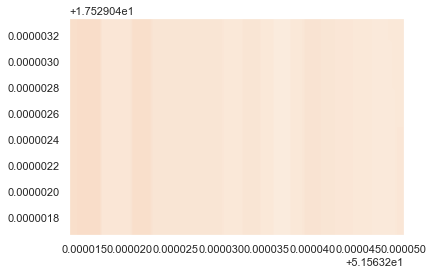

In [30]:
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.mlab import griddata
from scipy.interpolate import griddata

from geopandas import GeoDataFrame
from shapely.geometry import Polygon, MultiPolygon


def convert_to_hex(rgba_color) :
    red = str(hex(int(rgba_color[0]*255)))[2:].capitalize()
    green = str(hex(int(rgba_color[1]*255)))[2:].capitalize()
    blue = str(hex(int(rgba_color[2]*255)))[2:].capitalize()

    if blue=='0':
        blue = '00'
    if red=='0':
        red = '00'
    if green=='0':
        green='00'

    return '#'+ red + green + blue


def collec_to_gdf(collec_poly):
    """Transform a `matplotlib.contour.QuadContourSet` to a GeoDataFrame"""
    polygons = []
    for i, polygon in enumerate(collec_poly.collections):
        mpoly = []
        for path in polygon.get_paths():
            try:
                path.should_simplify = False
                poly = path.to_polygons()
                # Each polygon should contain an exterior ring + maybe hole(s):
                exterior, holes = [], []
                if len(poly) > 0 and len(poly[0]) > 3:
                    # The first of the list is the exterior ring :
                    exterior = poly[0]
                    # Other(s) are hole(s):
                    if len(poly) > 1:
                        holes = [h for h in poly[1:] if len(h) > 3]
                mpoly.append(Polygon(exterior, holes))
            except:
                print('Warning: Geometry error when making polygon #{}'
                      .format(i))
        if len(mpoly) > 1:
            mpoly = MultiPolygon(mpoly)
            polygons.append(mpoly)
        elif len(mpoly) == 1:
            polygons.append(mpoly[0])
    return GeoDataFrame(geometry=polygons, crs={'init': 'epsg:4326'})

data = np.genfromtxt('temp copy.csv', delimiter=',')
x = data[..., 1]
y = data[..., 2]
z = data[..., 4]
xi = np.linspace(x.min(), x.max(), num=100)
yi = np.linspace(y.min(), y.max(), num=100)

#zi = griddata(x, y, z, xi, yi, interp='nn') # You could also take a look to scipy.interpolate.griddata
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='nearest')

nb_class = [5,10,15,20,25,30,35,40,45,50] # Set the number of class for contour creation
nb_class = 20 
# The class can also be defined by their limits like [0, 122, 333]
collec_poly = plt.contourf(xi, yi, zi, nb_class, vmax=abs(zi).max(), vmin=-abs(zi).max())


gdf = collec_to_gdf(collec_poly)
gdf.to_json()
colors = [p.get_facecolor().tolist()[0] for p in collec_poly.collections]
gdf['RGBA'] = colors

convert_color = lambda rgba_color : convert_to_hex(rgba_color)
gdf['RGBA'] = list(map(convert_color, colors))
#print(gdf.to_json())
#plt.plot(x,y)
#plt.show()
gdf['geometry']

In [19]:
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson


cols = ['street_address', 'issue_type', 'status']
geojson = df_to_geojson(df, cols)

output_filename = 'dataset.js'
with open(output_filename, 'wb') as output_file:
    output_file.write('var dataset = ')
    json.dump(geojson, output_file, indent=2) 
    
    
    
    
geoJsonData = {
    "features": [
        {
            "geometry": {
                "coordinates": [
                    [
                        12.98583984375,
                        56.70450561416937
                    ],
                    [
                        14.589843749999998,
                        57.604221411628735
                    ],
                    [
                        13.590087890625,
                        58.15331598640629
                    ],
                    [
                        11.953125,
                        57.955674494979526
                    ],
                    [
                        11.810302734375,
                        58.76250326278713
                    ]
                ],
                "type": "LineString"
            },
            "properties": {
                "stroke": "#fc1717",
                "stroke-opacity": 1,
                "stroke-width": 2
            },
            "type": "Feature"
        }
    ],
    "type": "FeatureCollection"
}

NameError: name 'df' is not defined

In [43]:
#gdf.geometry.unique()
gdf.iloc[0]['geometry'][0]

TypeError: 'Polygon' object does not support indexing

In [32]:
from shapely import geometry

upcast_dispatch = {geometry.Point: geometry.MultiPoint, 
                   geometry.LineString: geometry.MultiLineString, 
                   geometry.Polygon: geometry.MultiPolygon}

def maybe_cast_to_multigeometry(geom):
    caster = upcast_dispatch.get(type(geom), lambda x: x[0])
    return caster([geom])


gdf.geometry.apply(maybe_cast_to_multigeometry)

0     (POLYGON ((51.56321444412121 17.529041667, 51....
1     (POLYGON ((51.56321370337374 17.529041667, 51....
2     (POLYGON ((51.56321674932735 17.52904168382829...
3     (POLYGON ((51.56321678093258 17.52904168382829...
4     (POLYGON ((51.5632168125378 17.52904168382829,...
5     (POLYGON ((51.56321684414303 17.52904168382828...
6     (POLYGON ((51.56321687574825 17.52904168382829...
7     (POLYGON ((51.56321690735348 17.52904168382829...
8     (POLYGON ((51.5632169389587 17.52904168382829,...
9     (POLYGON ((51.56321697056393 17.52904168382829...
10    (POLYGON ((51.56321700216915 17.52904168382829...
11    (POLYGON ((51.56321703377438 17.52904168382829...
12    (POLYGON ((51.56321703673737 17.529041667, 51....
13    (POLYGON ((51.56323037019192 17.529041667, 51....
14    (POLYGON ((51.56323444430303 17.529041667, 51....
15    (POLYGON ((51.56323570357374 17.52904168382829...
16    (POLYGON ((51.56323577942628 17.52904168382829...
17    (POLYGON ((51.56323585527882 17.5290416838

In [28]:
gdf.to_file('./poland.geojson', driver='GeoJSON')
geojson = json.load(open("./poland.geojson"))
geojson

GeometryTypeValidationError: Record's geometry type does not match collection schema's geometry type: 'MultiPolygon' != 'Polygon'

In [21]:
import folium
import json
maploc = folium.Map(location=[np.mean(x),np.mean(y)],zoom_start=10,tiles="Stamen Terrain")


colors = []
folium.GeoJson(
    json.load(open("./poland.geojson")),
    style_function=lambda feature: {
        'fillColor': feature['properties']['RGBA'],
        'color' : feature['properties']['RGBA'],
        'weight' : 1,
        'fillOpacity' : 0.5,
        }
    ).add_to(maploc)

maploc

In [131]:
import folium
geoJsonData = {
    "features": [
        {
            "geometry": {
                "coordinates": [
                    [
                        12.98583984375,
                        56.70450561416937
                    ],
                    [
                        14.589843749999998,
                        57.604221411628735
                    ],
                    [
                        13.590087890625,
                        58.15331598640629
                    ],
                    [
                        11.953125,
                        57.955674494979526
                    ],
                    [
                        11.810302734375,
                        58.76250326278713
                    ]
                ],
                "type": "LineString"
            },
            "properties": {
                "stroke": "#fc1717",
                "stroke-opacity": 1,
                "stroke-width": 2
            },
            "type": "Feature"
        },
        {
            "geometry": {
                "coordinates": [
                    [
                        14.9468994140625,
                        57.7569377956732
                    ],
                    [
                        15.078735351562498,
                        58.06916140721414
                    ],
                    [
                        15.4302978515625,
                        58.09820267068277
                    ],
                    [
                        15.281982421875002,
                        58.318144965188246
                    ],
                    [
                        15.4852294921875,
                        58.36427519285588
                    ]
                ],
                "type": "LineString"
            },
            "properties": {
                "stroke": "#1f1a95",
                "stroke-opacity": 1,
                "stroke-width": 2
            },
            "type": "Feature"
        }
    ],
    "type": "FeatureCollection"
}
m = folium.Map(location=[ 56.7, 12.9], zoom_start=6)
folium.GeoJson(geoJsonData,
    style_function=lambda x: {
        'color' : x['properties']['stroke'],
        'weight' : x['properties']['stroke-width'],
        'opacity': 0.6
        }).add_to(m)
m

In [51]:
import pyart
filename = 'KENXd20161226t1800.cfradial'
da = pyart.io.read_cfradial(filename)
da

In [136]:
from shapely import geometry

def createCircleAroundWithRadius(lat, lon, radiusMiles):
    latArray = []
    lonArray = []
 
    for brng in range(0,360,5):
        lat2, lon2 = getLocation(lat,lon,brng,radiusMiles)
        latArray.append(lat2)
        lonArray.append(lon2)

    return lonArray,latArray


def getLocation(lat1, lon1, brng, distanceMiles):
    lat1 = lat1 * math.pi/ 180.0
    lon1 = lon1 * math.pi / 180.0
    #earth radius
    #R = 6378.1Km
    #R = ~ 3959 MilesR = 3959
    R = 3959
        
    distanceMiles = distanceMiles/R
    
    brng = (float(brng) / 90)* math.pi / 2
    
    lat2 = math.asin(math.sin(lat1) * math.cos(distanceMiles) 
                     + math.cos(lat1) * math.sin(distanceMiles) * math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(distanceMiles)
                             * math.cos(lat1),math.cos(distanceMiles)-math.sin(lat1)*math.sin(lat2))
        
    lon2 = 180.0 * lon2/ math.pi
    lat2 = 180.0 * lat2/ math.pi
    
    return lat2, lon2



centroidLat = centroid_coord[0]
centroidLon = centroid_coord[1]
distanceInMiles = 50


# retrieve X and Y radius values using center point, draw 50 miles out
lons,  lats = createCircleAroundWithRadius(centroidLat, centroidLon, distanceInMiles)
print(len(lats),len(lons))

pointList = [geometry.Point(i[0], i[1]) for i in list(zip(lats, lons))]
shapely_polygon = geometry.Polygon([[p.x, p.y] for p in pointList])
print(shapely_polygon.wkt) 

72 72
POLYGON ((42.15972270834904 -89.6095793968308, 42.15693800473336 -89.52450627939444, 42.14860581899643 -89.44010274695704, 42.13479173602959 -89.35703258300377, 42.11560443145001 -89.27594803595886, 42.0911947306659 -89.19748422015489, 42.06175430712789 -89.12225371508677, 42.02751403492613 -89.05084142267511, 41.98874201466823 -88.98379973709719, 41.94574129496168 -88.92164407564333, 41.89884731476992 -88.86484881222029, 41.84842509437404 -88.81384364778204, 41.79486620462771 -88.76901044434665, 41.73858554563434 -88.73068054158277, 41.68001796690931 -88.69913256742929, 41.61961476153822 -88.67459074703811, 41.55784006683614 -88.65722370766085, 41.49516720359624 -88.64714377106544, 41.43207498523635 -88.64440671976385, 41.36904402706335 -88.64901201881409, 41.30655308453237 -88.66090347125946, 41.24507544783466 -88.67997028237737, 41.18507541845929 -88.70604850580528, 41.12700489158459 -88.73892284323405, 41.07130006631408 -88.77832876864723, 41.01837830391123 -88.8239549479526,

In [137]:
import json
import pprint
import geopandas


geopandas.GeoSeries([shapely_polygon]).__geo_interface__
gdf1 = geopandas.GeoSeries([shapely_polygon])
#print(gdf1.iloc[0])
#print(gdf1.total_bounds)
#print(gdf1.bounds)

#geoJsonData = geopandas.GeoSeries([shapely_polygon]).to_json()
gdf1.to_file('./data.geojson', driver='GeoJSON')
#pprint.pprint(geoJsonData)
   
with open('data.geojson', 'r') as f:
    geoJsonData = json.load(f)
    
    
#A Python dictionary containing properties to be added to each GeoJSON Feature
properties_dict={
    "stroke": "#56ea0b",
    "stroke-width": 3
    }

#Convert the dictionary to a list
properties_list= list(zip(properties_dict.keys(),properties_dict.values()))


#Loop over GeoJSON features and add the new properties
for feat in geoJsonData['features']:
    for i in range(len(properties_list)):
        feat['properties'][properties_list[i][0]]=properties_list[i][1]
    

#Write result to a new file
with open('newdata.geojson', 'w') as f:
    json.dump(geoJsonData, f)

with open('newdata.geojson', 'r') as f:
    newGeoJsonData = json.load(f)


#pprint.pprint(newGeoJsonData)


m = folium.Map(location=[ np.mean(lats), np.mean(lons)], zoom_start=10)
folium.GeoJson(newGeoJsonData,
    style_function=lambda x: {
        'color' :  x['properties']['stroke'],
        'weight' : x['properties']['stroke-width'],
        'opacity': 0.6
        }).add_to(m)
m

### Heatmap for folium

https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set

https://alysivji.github.io/getting-started-with-folium.html


### Colormap for LayerControl
https://nbviewer.jupyter.org/gist/BibMartin/f153aa957ddc5fadc64929abdee9ff2e


https://python-visualization.github.io/folium/modules.html#folium.vector_layers.path_options


https://stackoverflow.com/questions/23201134/transparent-argb-hex-value

## Contour in Folium 


https://github.com/python-visualization/folium/issues/958



http://technocyclist.blogspot.com/2014/10/plot-contour-polygons-in-leaflet-using-r.html



https://nbviewer.jupyter.org/gist/ocefpaf/78095b6e5d22723aae3bf05e5600e165



https://stackoverflow.com/questions/26872337/how-can-i-get-my-contour-plot-superimposed-on-a-basemap



https://matplotlib.org/basemap/users/examples.html



https://rabernat.github.io/research_computing/intro-to-basemap.html



https://stackoverflow.com/questions/34886899/contour-plot-data-lat-lon-value-within-boundaries-and-export-geojson



https://stackoverflow.com/questions/35516318/plot-colored-polygons-with-geodataframe-in-folium



https://moderndata.plot.ly/weather-maps-in-python-with-mapbox-gl-xarray-and-netcdf4/



https://plot.ly/~jackp/18301.embed



http://darribas.org/gds15/content/labs/lab_03.html



## Legend and icons for html

https://www.w3schools.com/icons/tryit.asp?filename=tryicons_awesome5



https://fontawesome.com/icons/diamond?style=solid



https://fontawesome.com/icons?d=gallery



# Maps

https://medium.com/@bobhaffner/creating-a-legend-for-a-folium-map-c1e0ffc34373


https://blog.exploratory.io/visualizing-geospatial-data-with-your-own-geojson-f96dde0f6296


https://github.com/bobhaffner/medium_posts/blob/master/folium_legend/folium_legend.ipynb


https://github.com/python-visualization/folium/issues/1010


https://github.com/python-visualization/folium/issues/946

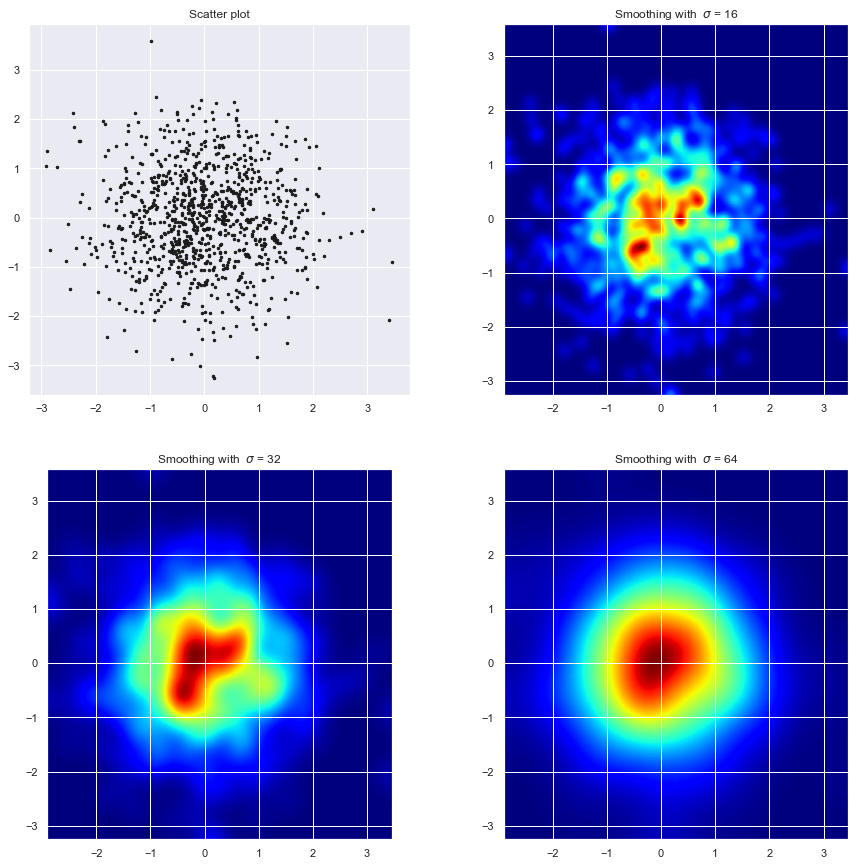

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2, figsize=(15,15))

# Generate some test data
x = np.random.randn(1000)
y = np.random.randn(1000)

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

/Users/ducvu/anaconda3/envs/map-gen/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


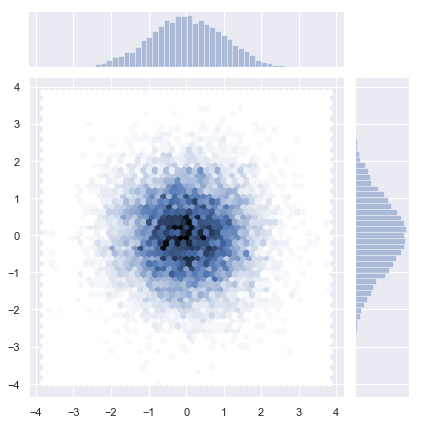

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some test data
x = np.random.randn(8873)
y = np.random.randn(8873)
x = np.random.randn(9999)
y = np.random.randn(9999)
#x = np.random.randn(100000)
#y = np.random.randn(100000)

sns.jointplot(x=x, y=y, kind='hex')
plt.show()

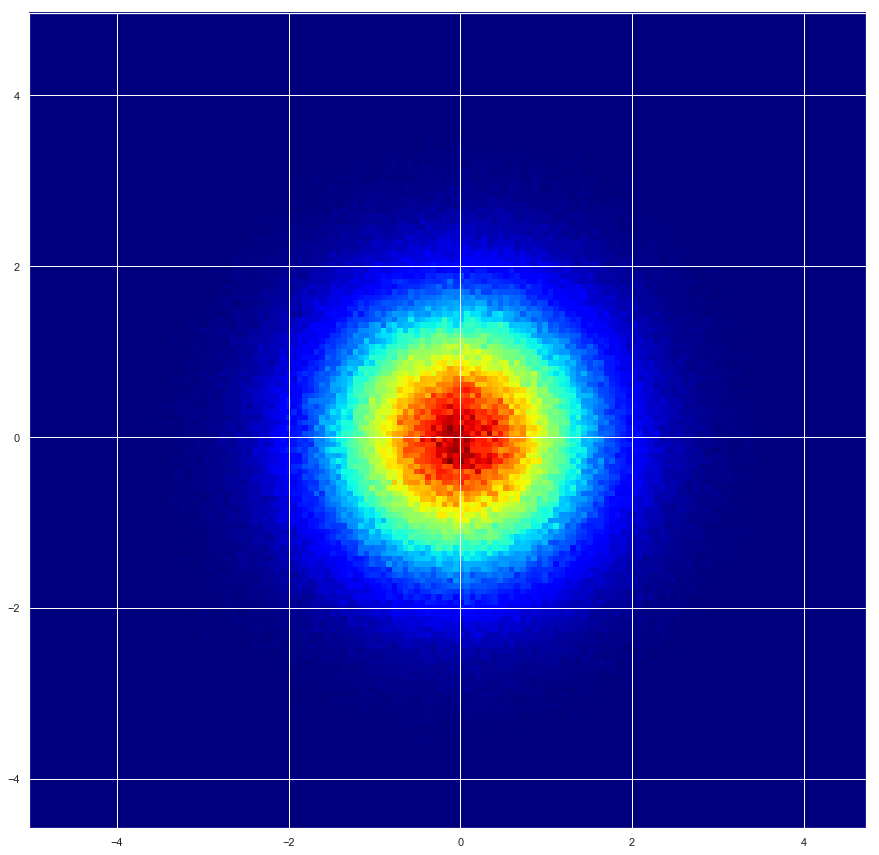

In [16]:
import numpy as np
import matplotlib.pyplot as plt

pts = 1000000
mean = [0.0, 0.0]
cov = [[1.0,0.0],[0.0,1.0]]

x,y = np.random.multivariate_normal(mean, cov, pts).T
plt.figure(figsize=(15,15)) 
plt.hist2d(x, y, bins=150, cmap=plt.cm.jet)
plt.show()

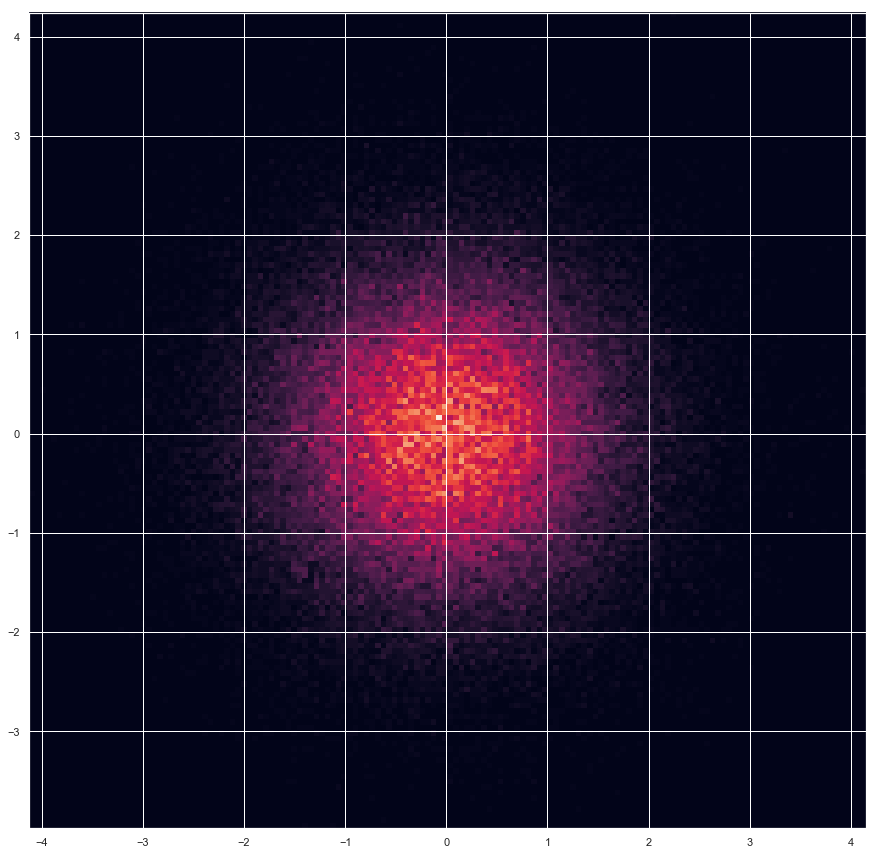

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.randn(100000)
y = np.random.randn(100000)
plt.figure(figsize=(15,15)) 
plt.hist2d(x,y,bins=150)
plt.show()

## https://www.tjansson.dk/2018/10/contour-map-in-folium/

http://qingkaikong.blogspot.com/2016/06/using-folium-5-image-overlay-overlay.html


https://www.python-course.eu/matplotlib_contour_plot.php

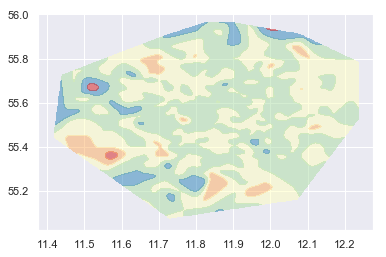

In [18]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
 
# Setup
temp_mean = 12
temp_std  = 2
debug     = False
 
# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)
 
# Create a dataframe with fake data
df = pd.DataFrame({
    'longitude':   np.random.normal(11.84,     0.15,     1000),
    'latitude':    np.random.normal(55.55,     0.15,     1000),
    'temperature': np.random.normal(temp_mean, temp_std, 1000)})
 
# The original data
x_orig = np.asarray(df.longitude.tolist())
y_orig = np.asarray(df.latitude.tolist())
z_orig = np.asarray(df.temperature.tolist())
 
# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 
# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
 
# Gaussian filter the grid to make it smoother
sigma = [5, 5]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')
 
# Create the contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)
 
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)
 
# Set up the folium plot
geomap = folium.Map([df.latitude.mean(), df.longitude.mean()], zoom_start=10, tiles="cartodbpositron")
 
# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)
 
# Add the colormap to the folium map
cm.caption = 'Temperature'
geomap.add_child(cm)
 
# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
 
# Plot the data
geomap.save('folium_contour_temperature_map.html')

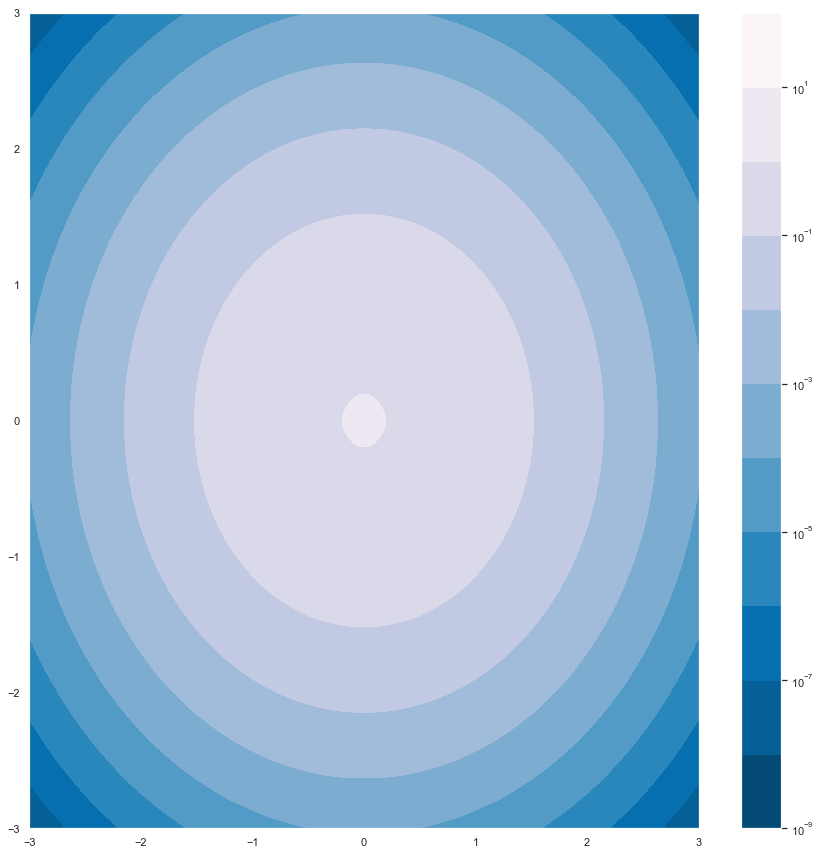

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

N = 100
x = np.linspace(-3.0, 3.0, N)
y = np.linspace(-3.0, 3.0, N)

X, Y = np.meshgrid(x, y)

# A low hump with a spike coming out.
# Needs to have z/colour axis on a log scale so we see both hump and spike.
# linear scale only shows the spike.
Z1 = np.exp(-(X)**2 - (Y)**2)
Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
z = Z1 + 50 * Z2
z = Z1 + Z2
# Put in some negative values (lower left corner) to cause trouble with logs:
#z[:5, :5] = -1

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots(figsize=(15,15))

cs = ax.contourf(X, Y, z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)

# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

cbar = fig.colorbar(cs)

plt.show()

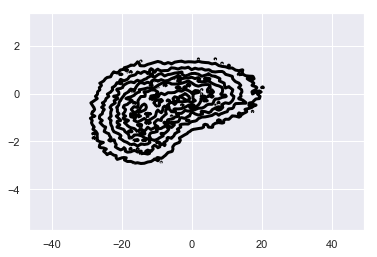

In [20]:
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

plt.interactive(True)
fig=plt.figure(1)
plt.clf()

# generate input data; you already have that
x1 = np.random.normal(0,10,100000)
y1 = np.random.normal(0,7,100000)/10.
x2 = np.random.normal(-15,7,100000)
y2 = np.random.normal(-10,10,100000)/10.
x=np.concatenate([x1,x2])
y=np.concatenate([y1,y2])

# calculate the 2D density of the data given
counts,xbins,ybins=np.histogram2d(x,y,bins=100,normed=LogNorm())
# make the contour plot
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=3,colors='black',
    linestyles='solid')
plt.show()

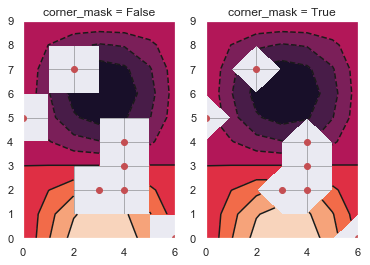

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot.
x, y = np.meshgrid(np.arange(7), np.arange(10))
z = np.sin(0.5 * x) * np.cos(0.52 * y)

# Mask various z values.
mask = np.zeros_like(z, dtype=bool)
mask[2, 3:5] = True
mask[3:5, 4] = True
mask[7, 2] = True
mask[5, 0] = True
mask[0, 6] = True
z = np.ma.array(z, mask=mask)

corner_masks = [False, True]
fig, axs = plt.subplots(ncols=2)
for ax, corner_mask in zip(axs, corner_masks):
    cs = ax.contourf(x, y, z, corner_mask=corner_mask)
    ax.contour(cs, colors='k')
    ax.set_title('corner_mask = {0}'.format(corner_mask))

    # Plot grid.
    ax.grid(c='k', ls='-', alpha=0.3)

    # Indicate masked points with red circles.
    ax.plot(np.ma.array(x, mask=~mask), y, 'ro')

plt.show()

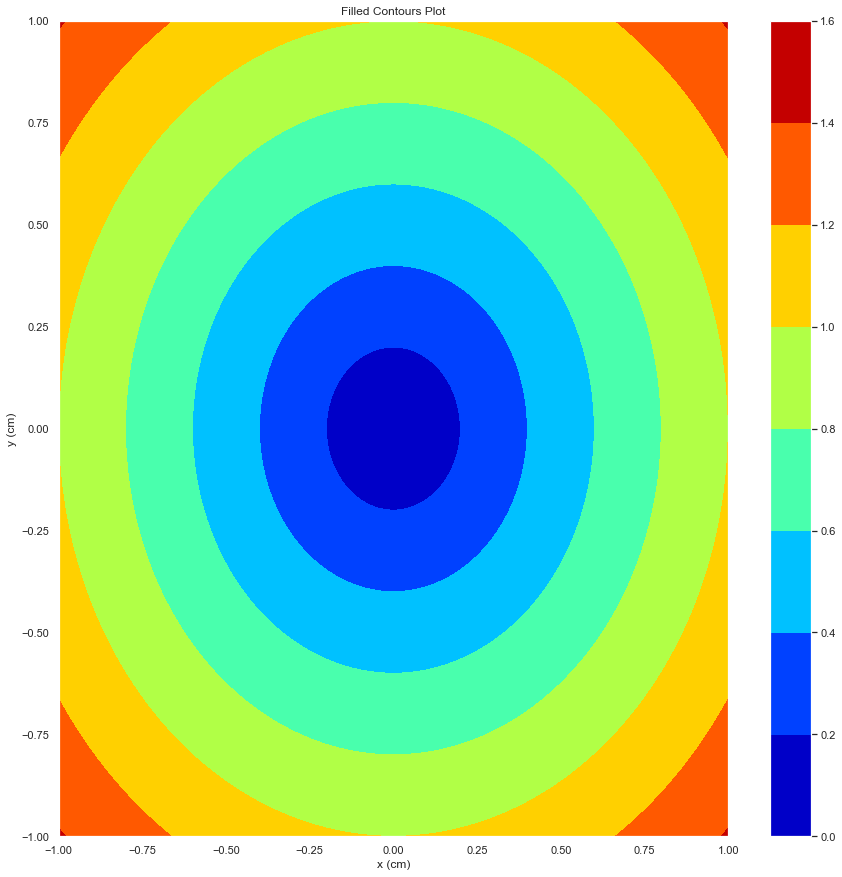

In [22]:
import numpy as np
import matplotlib.pyplot as plt


xlist = np.linspace(-1.0, 1.0, 1000)
ylist = np.linspace(-1.0, 1.0, 1000)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)
plt.figure(figsize=(15, 15))
cp = plt.contourf(X, Y, Z,cmap=plt.cm.jet)
plt.colorbar(cp)
plt.title('Filled Contours Plot')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.show()

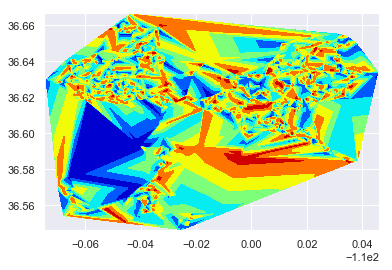

In [21]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage


# Set up the folium plot
m = folium.Map(centroid_coord, zoom_start=10, tiles="cartodbpositron")

heat_data, heat_data_dp, df_heat_map = generate_heat_data(df_line)



# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = np.min(df_heat_map.probability)
vmax   = np.max(df_heat_map.probability)
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)





# The original data
x_orig = np.asarray(df_heat_map.lon.tolist())
y_orig = np.asarray(df_heat_map.lat.tolist())
z_orig = np.asarray(df_heat_map.probability.tolist())
 
# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 5000)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 5000)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 

# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
 
# Gaussian filter the grid to make it smoother
sigma = [5, 5]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')

'''
z_mesh = np.sqrt(x_mesh**2 + y_mesh**2)
'''
# Create the contour
#contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax, cmap=plt.cm.jet)
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, cmap=plt.cm.jet)




# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)

# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(m)


# Add the colormap to the folium map
cm.caption = 'Temperature'
m.add_child(cm)

# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(m)
 
# Plot the data
m.save('map.html')

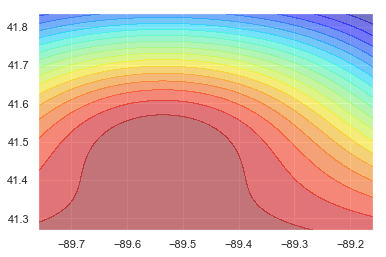

In [27]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
 
# Setup
debug     = False
 
# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=0, vmax=1).to_step(levels)
 

# Create a dataframe with fake data
df = pd.DataFrame({
    'longitude':   np.random.normal(centroid_coord[1],    0.075,     10000),
    'latitude':    np.random.normal(centroid_coord[0],    0.075,     10000),
    'probability': np.random.normal(0, 1, 10000)})
 
    
pts = 1000000
mean = [centroid_coord[1], centroid_coord[0]]
cov = [[1.0,0.0],[0.0,1.0]]

#x_orig, y_orig = np.random.multivariate_normal(mean, cov, pts).T

# The original data
x_orig = np.asarray(df.longitude.tolist())
y_orig = np.asarray(df.latitude.tolist())
z_orig = np.asarray(df.probability.tolist())
 
# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 1000)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 1000)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 
wave = 0.75*(np.sin(2.*y_mesh)**8*np.cos(4.*x_mesh))
mean = 0.5*np.cos(2.*y_mesh)*((np.sin(2.*y_mesh))**2 + 2.)
z_mesh = wave + mean


#Z1 = np.exp(-(x_mesh)**2 - (y_mesh)**2)
#Z2 = np.exp(-(x_mesh * 10)**2 - (y_mesh * 10)**2)
#z_mesh = Z1 + 50 * Z2
#z_mesh = Z1 + Z2
#z_mesh = np.sqrt(x_mesh**2 + y_mesh**2)

#z_mesh = np.sin(x_mesh**2 + y_mesh**2) / (x_mesh**2 + y_mesh**2)

# Grid the values
#z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='cubic')
 
# Gaussian filter the grid to make it smoother
#sigma = [5, 5]
#z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')
 
# Create the contour
#contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors)
nb_class = 20
contourf = plt.contourf(x_mesh, y_mesh, z_mesh,  nb_class,alpha=0.5, cmap=plt.cm.jet)
 
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)
 
# Set up the folium plot
geomap = folium.Map([df.latitude.mean(), df.longitude.mean()], zoom_start=10, tiles="cartodbpositron")

folium.CircleMarker(
    location=centroid_coord,
    radius=50,
    popup='Laurelhurst Park',
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(geomap)



tooltip = '<i>center</i>'
folium.Marker(centroid_coord, popup='<i>center</i>', tooltip=tooltip).add_to(geomap)


# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)
 
# Add the colormap to the folium map
cm.caption = 'Probability'
geomap.add_child(cm)
 
# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
 
# Plot the data
geomap.save('probability_map.html')

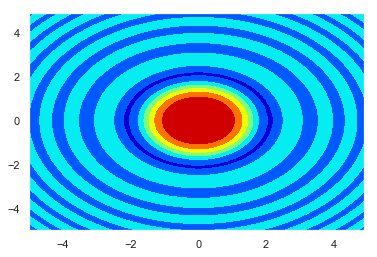

In [49]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
h = plt.contourf(x,y,z, cmap=plt.cm.jet)
plt.show()

In [57]:
def createCircleAroundWithRadius(lat, lon, radiusMiles):
    latArray = []
    lonArray = []
 
    for brng in range(0,360):
        lat2, lon2 = getLocation(lat,lon,brng,radiusMiles)
        latArray.append(lat2)
        lonArray.append(lon2)

    return lonArray,latArray


def getLocation(lat1, lon1, brng, distanceMiles):
    lat1 = lat1 * math.pi/ 180.0
    lon1 = lon1 * math.pi / 180.0
    #earth radius
    #R = 6378.1Km
    #R = ~ 3959 MilesR = 3959
    R = 3959
        
    distanceMiles = distanceMiles/R
    
    brng = (float(brng) / 90)* math.pi / 2
    
    lat2 = math.asin(math.sin(lat1) * math.cos(distanceMiles) 
                     + math.cos(lat1) * math.sin(distanceMiles) * math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(distanceMiles)
                             * math.cos(lat1),math.cos(distanceMiles)-math.sin(lat1)*math.sin(lat2))
        
    lon2 = 180.0 * lon2/ math.pi
    lat2 = 180.0 * lat2/ math.pi

    return lat2, lon2



centroidLat = centroid_coord[0]
centroidLon = centroid_coord[1]
distanceInMiles = 50


# retrieve X and Y radius values using center point, draw 50 miles out
X,Y = createCircleAroundWithRadius(centroidLat, centroidLon, distanceInMiles)
len(X),len(Y)

(360, 360)

## 2. Translate and rotate one grid to another grid

In [ ]:
def combine_grids(data_path, data_name_1, data_name_2, default_coord, scale_x_1, scale_y_1, scale_x_2, scale_y_2):

    data_pickle_1 = data_path + data_name_1
    data_pickle_2 = data_path + data_name_2
    
    name_1 = data_name_1.split('/')[0] 
    name_2 = data_name_2.split('/')[0]
    
    df_node_1, df_line_1, centroid_coord_1 = generate_dataframe(data_pickle_1, default_coord, scale_x_1, scale_y_1)
    df_node_2, df_line_2, centroid_coord_2 = generate_dataframe(data_pickle_2, default_coord, scale_x_2, scale_y_2)
    
    
    df_node_new, df_line_new = offset_latlon(df_node_1, df_line_1)
    
    
    print(df_node_1.iloc[-1], df_node_2.iloc[-1])
    
    #calculate_distance_latlon(origin, destination)  
    spherical_distance(df_node_1.iloc[-1][['lat', 'lon']].tolist(), df_node_2.iloc[-1][['lat', 'lon']].tolist())
    
    centroid_coord = [sum(i)/len(i) for i in list(zip(centroid_coord_1, centroid_coord_2))]
    
    graph_map = generate_baseMap(default_location=centroid_coord)
    
    #Update basemap with Polyline Layer
    graph_map = add_polyline(graph_map, 
                             df_line_1, 
                             attr = ['Node A', 'Node B'],
                             layer_name = 'Grid ' + name_1,
                             info_name = 'Line Information')

    graph_map = add_polyline(graph_map, 
                             df_line_2, 
                             attr = ['Node A', 'Node B'],
                             layer_name = 'Grid ' + name_2,
                             prob_name = '#E22706', 
                             info_name = 'Line Information')

    graph_map = add_polyline(graph_map, 
                             df_line_new, 
                             attr = ['Node A', 'Node B'],
                             layer_name = 'Translated Grid ' + name_2,
                             prob_name = '#339FFF', 
                             info_name = 'Line Information')

    node_icon = 'https://raw.githubusercontent.com/dvu4/grid_folium/master/data/Blue_icon.png'

    
    #Update basemap with point cluster layer
    graph_map = add_point_clusters(graph_map, 
                                   df_node_1, 
                                   attr = ['Node', 'lat', 'lon'], 
                                   node_image = node_icon, 
                                   node_name = 'Node '+ name_1,
                                   info_name = 'Node Information')
    
     #Update basemap with point cluster layer
    graph_map = add_point_clusters(graph_map, 
                                   df_node_2, 
                                   attr = ['Node', 'lat', 'lon'], 
                                   node_image = node_icon, 
                                   node_name = 'Node ' + name_2,
                                   info_name = 'Node Information')
       

    graph_map = add_point_clusters(graph_map, 
                                   df_node_new,
                                   attr = ['Node', 'lat', 'lon'], 
                                   node_image = node_icon, 
                                   node_name = 'Translated Node ' + name_2,
                                   info_name = 'Node Information')
 
    '''
    graph_map = add_point_clusters(graph_map, 
                                   df_node_3, 
                                   attr = ['Node', 'lat', 'lon'], 
                                   node_image = node_icon, 
                                   node_name = 'Another Translated Node ' + name_2,
                                   info_name = 'Node Information')    
    '''

    
    #Update heatmap 
    
    # List comprehension to make out list of lists
    #heat_data_1 = [[row["lat"], row["lon"]] for idx, row in df_node_1.iterrows()]
    #heat_data_2 = [[row["lat"], row["lon"]] for idx, row in df_node_2.iterrows()]
    
       
    heat_name_1 = 'probability failure for ' + name_1
    heat_name_2 = 'probability failure for ' + name_2
    #colormap =  {0.4: 'blue', 0.65: 'green', 1: 'red'}
    #colormap = None
    #colormap =  {.6: 'blue', .98: 'lime', 1: 'red'}
    #colormap = {0.0: 'pink', 0.3: 'blue', 0.5: 'green',  0.7: 'yellow', 1.0: 'red'}
        
    heat_data_1 = generate_heat_data(df_line_1)
    heat_data_2 = generate_heat_data(df_line_2)
    heat_data_new = generate_heat_data(df_line_new)
    
    # Plot it on the map
    #HeatMap(heat_data_1).add_to(graph_map)
    #HeatMap(heat_data_2).add_to(graph_map)  
    #HeatMap(heat_data_new).add_to(graph_map)
       
    HeatMap(heat_data_1, name = heat_name_1, radius = 10, max_zoom=10).add_to(graph_map)
    HeatMap(heat_data_2, name = heat_name_2, radius = 10, max_zoom=10).add_to(graph_map)
    HeatMap(heat_data_new, name = 'new', radius = 10, max_zoom=10).add_to(graph_map)
    
    folium.TileLayer('stamentoner').add_to(graph_map)
    folium.TileLayer('stamenwatercolor').add_to(graph_map)
    folium.TileLayer('openstreetmap').add_to(graph_map)
    folium.TileLayer('cartodbdark_matter').add_to(graph_map)
    folium.TileLayer('cartodbpositron').add_to(graph_map)
    
    # Fullscreen
    plugins.Fullscreen(position='topright',
                       title='Expand me',
                       title_cancel='Exit me',
                       force_separate_button=True).add_to(graph_map)


    graph_map.add_child(folium.LayerControl()) #Add layer control to toggle on/off

    filepath = os.getcwd() + '/' + name_1  +  '_' + name_2 + '.html'  
    graph_map.save(filepath)   
    IFrame(filepath, width=600, height=500) #display map
    return df_node_1, df_node_2, df_line_1, df_line_2, centroid_coord

In [ ]:
default_coord = [38.692918, -77.575285]

data_name_1 = data_names[0]
scale_x_1 = 2200000
scale_y_1 = 280000

data_name_2 = data_names[3]
scale_x_2 = 1600000
scale_y_2 = 12200000

df_node_1, df_node_2, df_line_1, df_line_2, centroid_coord = combine_grids(data_path, data_name_1, data_name_2, default_coord, scale_x_1, scale_y_1, scale_x_2, scale_y_2)

In [ ]:
import pyproj

# Coordinates in ft and false easting/northing in ft
x1,y1 = [1383566.534, 1627687.047]
sourceProjection =  "+proj=tmerc +lat_0=42 +lon_0=-115.5 +k=0.9996 +x_0=1640416 +y_0=328083 +datum=NAD83 +units=us-ft +no_defs"

x2,y2 = pyproj.transform(pyproj.Proj(sourceProjection), pyproj.Proj(init='epsg:4326'), x1, y1)

print("Original:    {0}, {1}".format(x1, y1))
print("Transformed: {0}, {1}".format(x2, y2)) 

In [ ]:
x1m = x1 * 1200.0/3937.0 
y1m = y1 * 1200.0/3937.0 
pm =  "+proj=tmerc +lat_0=42 +lon_0=-115.5 +k=0.9996 +x_0=502743 +y_0=100000 +datum=NAD83  +no_defs"
      "+proj=tmerc +lat_0=42 +lon_0=-115.5 +k=0.9996 +x_0=1640416 +y_0=328083 +datum=NAD83 +units=us-ft +no_defs"
pyproj.transform(pyproj.Proj(pm), pyproj.Proj("+init=epsg:4326"), x1m,y1m)

In [ ]:
pyproj.transform(pyproj.Proj("+proj=tmerc +lat_0=42 +lon_0=-115.5 +k=0.9996 +x_0=1640416 +y_0=328083 +datum=NAD83 +units=us-ft +no_defs"), pyproj.Proj("+init=epsg:4326"), x1m,y1m)

pnyc = pyproj.Proj( proj='tmerc', datum='NAD83', lat1=41.7557, lat2=41.6860, lat_0=origin_lat, lon_0=origin_lon, x_0=0, y_0=0.0)
lon, lat = pnyc(x, y, inverse=True)

In [ ]:
AllBusNames , AllLoadNames, AllLineNames, AllTransNames,  AllCapacitorNames, AllTransNames, AllSubNames, Circuit = import_dss_data(data_pickle)

listSubKeys = list(AllSubNames.keys())
print(listSubKeys)
AllSubNames['AllSubNames'] , AllSubNames['SubNumbers'], AllSubNames['181966'], 
#AllSubNames['x_1000582']['Coorddefined'] 
for i in listSubKeys[3:]:
    print(i, ' : ', AllSubNames[i],'\n')
    #print(i)

### Circle in Folium

http://mpickering.github.io/maps.html

https://github.com/mpickering/rg-map/blob/master/scripts/create-leaflet.py

### Add time dimension to map. 
https://www.kaggle.com/dabaker/fancy-folium/notebook

### Return None if Dictionary key is not available : `value = dictionary.get(missing_key, "empty")`

https://stackoverflow.com/questions/6130768/return-none-if-dictionary-key-is-not-available

### Aviation Formulary

- Algorithm for offsetting a latitude/longitude by some amount of meters

https://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters


http://www.edwilliams.org/avform.htm

https://www.johndcook.com/blog/2018/11/24/spheroid-distance/

https://www.movable-type.co.uk/scripts/latlong.html


https://gis.stackexchange.com/questions/299426/transform-coordinates-from-custom-projection-to-lat-long-pyproj

https://www.movable-type.co.uk/scripts/latlong.html

https://stackoverflow.com/questions/7222382/get-lat-long-given-current-point-distance-and-bearing


https://gis.stackexchange.com/questions/10808/manually-transforming-rotated-lat-lon-to-regular-lat-lon
    
    
https://math.stackexchange.com/questions/1917449/rotate-polygon-around-center-and-get-the-coordinates


https://stackoverflow.com/questions/7222382/get-lat-long-given-current-point-distance-and-bearing



In [ ]:
#Suppose point 1 is LAX: (33deg 57min N, 118deg 24min W)
#Suppose point 2 is JFK: (40deg 38min N,  73deg 47min W)

#0.592539, 
lat1=(33+57/60)*pi/180
#2.066470
lon1=(118+24/60)*pi/180

#(lat2=0.709186,lon2=1.287762)
lat2=(40+38/60)*pi/180
lon2=(73+47/60)*pi/180
print(lat1, lon1, lat2, lon2)


spherical_distance([lat1, lon1], [lat2, lon2])

In [ ]:
#!pip install geopy
import geopy
from geopy.distance import VincentyDistance

def calculate_new_latlon_geopy(lat1, lon1):
    # given: lat1, lon1, b = bearing in degrees, d = distance in kilometers
    b = 2*np.pi
    d = 68

    origin = geopy.Point(lat1, lon1)
    destination = VincentyDistance(kilometers=d).destination(origin, b)

    lat2, lon2 = destination.latitude, destination.longitude
    
    return lat2, lon2

new_location = lambda x: calculate_new_latlon_geopy(x[0], x[1])

location_list = list(map(new_location, list(zip(df_node_1['lat'], df_node_1['lon']))))

df_node_4 = pd.DataFrame(location_list, columns=['lat', 'lon'])
df_node_4['Node'] = df_node_1['Node']
df_node_4 = df_node_4[['Node', 'lat', 'lon']]
#df_node_4.head()


df_line_4 = df_line_1.drop(['Node_A_coord', 'Node_B_coord', 'Node_AB_coord'], 1)
df_line_4 = find_geometry_points(df_node_4, df_line_4)
df_line_4.head()

In [ ]:
from math import sin, cos, asin, atan, degrees, radians

def calculate_new_latlon(lat1, lon1):
    R = 6378.1 #Radius of the Earth
    
    bearing = 1.57 #Bearing is 90 degrees converted to radians.
    #bearing = 0 #Bearing is 90 degrees converted to radians.
    
    d = 68.77566265214419 #Distance in km
    #d = 20 #Distance in km

    lat1 = radians(lat1) #Current lat point converted to radians
    lon1 = radians(lon1) #Current long point converted to radians

    lat2 = asin( sin(lat1) * cos(d/R) + cos(lat1) * sin(d/R) * cos(bearing))

    lon2 = lon1 + atan2( sin(bearing) * sin(d/R) * cos(lat1), cos(d/R) - sin(lat1) * sin(lat2))

    lat2 = degrees(lat2)
    lon2 = degrees(lon2)
    
    return lat2, lon2


new_location = lambda x: calculate_new_latlon(x[0], x[1])

location_list = list(map(new_location, list(zip(df_node_2['lat'], df_node_2['lon']))))

df_node_3 = pd.DataFrame(location_list, columns=['lat', 'lon'])
df_node_3['Node'] = df_node_2['Node']
df_node_3 = df_node_3[['Node', 'lat', 'lon']]
#df_node_2.join(df_node_3, how='left')

#df_node_3.head()


df_line_3 = df_line_2.drop(['Node_A_coord', 'Node_B_coord', 'Node_AB_coord'], 1)
df_line_3 = find_geometry_points(df_node_3, df_line_3)
df_line_3.head()

In [ ]:
theta = radians(30)
R = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
R

In [ ]:
P = df_node_2.as_matrix(columns=df_node_2.columns[1:])
P = P.T
print(P.shape)
P

In [ ]:
lat = df_node_2.iloc[-1]['lat']
lon = df_node_2.iloc[-1]['lon']  
print(lat, lon)
lat = radians(lat)
lon = radians(lon)
print(lat, lon)

In [ ]:
R = 6378.1 #Radius of the Earth

brng = 1.57 #Bearing is 90 degrees converted to radians.
#brng = 0 #Bearing is 90 degrees converted to radians.
#d = 68.77566265214419 #Distance in km
d = 20 #Distance in km

#lat2  52.20444 - the lat result I'm hoping for
#lon2  0.36056 - the long result I'm hoping for.

#lat1 = math.radians(52.20472) #Current lat point converted to radians
#lon1 = math.radians(0.14056) #Current long point converted to radians

lat1, lon1 = df_node_1.iloc[-1][['lat', 'lon']].tolist()
orig_lat2, orig_lon2 = df_node_2.iloc[-1][['lat', 'lon']].tolist()

print('subbus 1 : {}, {}'.format(lat1, lon1))
print('subbus 2 : {}, {}'.format(orig_lat2, orig_lon2))

lat1 = math.radians(lat1) #Current lat point converted to radians
lon1 = math.radians(lon1) #Current long point converted to radians

lat2 = math.asin( math.sin(lat1)*math.cos(d/R) + 
                 math.cos(lat1)*math.sin(d/R)*math.cos(brng))

lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1), 
                         math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

lat2 = math.degrees(lat2)
lon2 = math.degrees(lon2)


print('new subbus 2 after moving close to subbus 1 : {}, {}'.format(lat2, lon2))

In [ ]:
#!pip install geopy
import geopy
from geopy.distance import VincentyDistance

# given: lat1, lon1, b = bearing in degrees, d = distance in kilometers
b = 0
d = 20

lat1, lon1 = df_node_1.iloc[-1][['lat', 'lon']].tolist()

origin = geopy.Point(lat1, lon1)
destination = VincentyDistance(kilometers=d).destination(origin, b)

lat2, lon2 = destination.latitude, destination.longitude

print('subbus 1 : {}, {}'.format(lat1, lon1))
print('new subbus 2 after moving close to subbus 1 : {}, {}'.format(lat2, lon2))

In [ ]:
ordered=dict(sorted(nodes.items(), key=lambda x: x[1],reverse=True)[:10])
ordered

### I am plotting gun violence incidents in the U.S. with folium FastMarkerCluster. The code bellow does the job rather well.


https://www.gunviolencearchive.org/query/1e1fc646-a270-420e-8b41-3f497794831f/map

https://python-forum.io/Thread-Folium-FastMarkerCluster

https://github.com/washingtonpost/data-school-shootings


In [ ]:
guns2018 = pd.read_csv('school-shootings-data.csv')
guns2018 = guns2018.rename(columns={'lat': 'latitude', 'long': 'longitude'})

# check Nan 
print(guns2018['latitude'].isnull().values.any())
print(guns2018['longitude'].isnull().values.any())

guns2018 = guns2018.dropna(subset = ['latitude', 'longitude']) 


lats2018 = guns2018['latitude'].tolist()
lons2018 = guns2018['longitude'].tolist()
 
locations = list(zip(lats2018, lons2018))
popups = ['lon:{}<br>lat:{}'.format(lons2018, lats2018) for (lats2018, 
lons2018) in locations]
icon_create_function = """\
function(cluster) {
return L.divIcon({
html: '<b>' + cluster.getChildCount() + '</b>',
className: 'marker-cluster marker-cluster-large',
iconSize: new L.Point(20, 20)
});
}"""
 
b = folium.Map(location=[np.mean(lats2018), np.mean(lons2018)], 
               tiles='Cartodb Positron', zoom_start=10)
 
marker_cluster = MarkerCluster(locations=locations, 
                               popups=popups, 
                               overlay=True,
                               control=True,
                               icon_create_function=icon_create_function)
 
marker_cluster.add_to(b)
folium.LayerControl().add_to(b)
 
b.save(outfile= "2018.html")

In [ ]:
#math.isnan(x)

In [ ]:
guns2018 

In [ ]:
import folium
import pandas as pd
from folium.plugins import HeatMap
 
#noro = pd.read_csv('norovirus.csv')
#heatNoro = [[row["lat"], row["lon"], row["amount"]] for idx, row in noro.iterrows()]
 


heatNoro = [[row["latitude"], row["longitude"], row["ulocale"]] for idx, row in guns2018.iterrows()]
 
mapNoro = folium.Map(location=[50.0, 10.3], tiles="cartodbpositron", zoom_start=6)
 
time_index_noro = [[row["date"]] for idx, row in guns2018.iterrows()]
 
mapNoro.add_child(HeatMapWithTime(heatNoro,
        index=time_index_noro,
        name='Norovirus',
        radius=30,
        min_opacity=0.1))
 
mapNoro.add_child(folium.LayerControl())
mapNoro.save('mapnoroheattest2.html')

## HEATMAP 

https://python-forum.io/Thread-Folium-HeatMapWithTime-is-not-displaying-data-point


https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-data



https://medium.freecodecamp.org/real-world-data-science-project-traffic-accident-analysis-e5a36775ee11



https://alysivji.github.io/getting-started-with-folium.html




https://programminghistorian.org/en/lessons/mapping-with-python-leaflet#exercise-5-custom-marker-icon
    

https://www.patrick-wied.at/static/heatmapjs/example-minimal-config.html

# From matplotlib to leaflet using mllpleaflet


https://automating-gis-processes.github.io/2018/notebooks/L5/interactive-map-folium.html


https://automating-gis-processes.github.io/2018/lessons/L5/share-on-github.html

In [ ]:
from folium.plugins import HeatMap

mapgun = folium.Map(location=[35.795556, -95.241921], tiles="cartodbpositron", zoom_start=6)

# List comprehension to make out list of lists
heat_data = [[row["latitude"], row["longitude"]] for idx, row in guns2018.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(mapgun)

mapgun.add_child(folium.LayerControl())
#mapgun.save('mapgun.html')
mapgun

In [ ]:
guns2018.head()

In [ ]:
from folium.plugins import HeatMap

centroid_coord = [ df_node_4['lat'].mean(), df_node_4['lon'].mean() ]

mapnode = folium.Map(location=centroid_coord , tiles="cartodbpositron", zoom_start=12)

# List comprehension to make out list of lists
heat_data = [[row["lat"], row["lon"]] for idx, row in df_node_4.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(mapnode)

mapnode.add_child(folium.LayerControl())
#mapnode.save('mapnode.html')
mapnode

In [ ]:
from folium.plugins import HeatMap

centroid_coord = [ df_node_1['lat'].mean(), df_node_1['lon'].mean() ]

mapnode = folium.Map(location=centroid_coord , tiles="cartodbpositron", zoom_start=12)

# List comprehension to make out list of lists
#heat_data = [[row["lat"], row["lon"]] for idx, row in df_node_4.iterrows()]


mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, len(df_line_4))
#s = [random.random() for i in range(len(df_line_4))]

c_coord = [(np.mean([node[0][0], node[1][0]]), np.mean([node[0][1], node[1][1]]) )  for node in df_line_4['Node_AB_coord'].tolist()]
df_new = pd.DataFrame(c_coord, columns=['c_lat', 'c_lon'])
df_new['probability'] = s

#heat_data = df_new.as_matrix()
heat_data = df_new.df_num.values

# Plot it on the map
HeatMap(heat_data).add_to(mapnode)

mapnode.add_child(folium.LayerControl())
mapnode.save('mapnode.html')
mapnode

https://python-visualization.github.io/folium/modules.html

https://python-visualization.github.io/folium/plugins.html

In [ ]:
lats = df_node['lat'].tolist()
lons = df_node['lon'].tolist()
 
locations = list(zip(lats, lons))
popups = ['lon:{}<br>lat:{}'.format(lons, lats) for (lats, lons) in locations]
icon_create_function = """\
function(cluster) {
return L.divIcon({
html: '<b>' + cluster.getChildCount() + '</b>',
className: 'marker-cluster marker-cluster-large',
iconSize: new L.Point(20, 20)
});
}"""
 
b = folium.Map(location=[np.mean(lats), np.mean(lons)], 
               tiles='stamentoner', zoom_start=12)
 
marker_cluster = MarkerCluster(locations=locations, 
                               popups=popups, 
                               overlay=True,
                               control=True,
                               icon_create_function=icon_create_function)
 
marker_cluster.add_to(b)
folium.LayerControl().add_to(b)
 
b.save(outfile= "b.html")
b